In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase
from matplotlib.gridspec import SubplotSpec

In [2]:
### Define parameters ###
# [version] is the SEVN2 version adopted                            e.g. '3.0.0-Spindevel_RLO'
# [Nsim] is the number of simulations                               e.g. '1mln'
# [Z] is the metallicity of the stars                               e.g. '02' for Z=0.02 solar metallicity
# [SN] is the SN explosion prescription adopted                     e.g. 'del' for delayed or 'com' for compact
# [n] number of cores involved in dask computation                  e.g.  4
# [Hsup] is the threshold for spectroscopic WR                      e.g. '0.3' for WR with H < 0.3 on surface
# [thres_RL] is the threshold for Roche Lobe filling binaries
# [thres_wind] is the threshold for wind fed binaries


Nsim = '1mln'
Zlist = ['0.15','02']
kicklist = ['hobbspure70','hobbspure265','hobbs265','unified265']
kicklabels = [r'Hobbs pure ($\sigma=70$ km/s)', r'Hobbs pure ($\sigma=265$ km/s)',r'Hobbs',r'Unified']
SNlist = ['rap','del','com']
SNlabels = ['Rapid','Delayed','Compactness']
ppisn = 'without'
version = '3.0.0-Spindevel_RLO'                                      # select SEVN2 version
n = 4                                                                # cores for dask computation
Hsup,thres_RL,thres_wind = 0.3,1.,0.8                                # for functions inside WRBH_select.py


dfname0 = 'BHBH_bound_WRBH'
dfname1 = 'BHBH_GW_WRBH'
dfname2 = 'BHBH_GW_WRBH_cyg_x-3--Ko17'

path_plots = './plots/'

# Functions

In [3]:
# third Kepler law
def KeplerA(M1,M2,P):
    # conversions
    Rsun = float(7e8)  #m   700 000 km
    Msun = float(2e30) #kg

    G = float(6.67e-11) #mks
    G4pi2 = float(G/(4*np.pi*np.pi))  # G/4*pi^2
    
    years = 60*60*24*365 # seconds in a year
    
    # convert everything into the mks systems because
    # M1, M2 are given in Msun
    # P is given in yrs as input
    M1mks = M1 * Msun
    M2mks = M2 * Msun
    Pmks = P * years
    
    # a^3/P^2 = (M1+M2)*G/4*pi^2
    amks = (Pmks*Pmks * (M1mks+M2mks)*G4pi2)**(1./3.)
    a = amks / Rsun  # Semimajor in Rsun
    return a

In [4]:
def removecol(df,colname):
    if colname in df.columns:
        df = df.drop(columns = [colname])
    return df

In [5]:
def Extract(dfname):
    # progenitors, remnants and initial and final istant of the selected WRBH type
    p = pd.read_csv(f'{path_results}/progenitors/p_{dfname}.csv')
    i = pd.read_csv(f'{path_results}/initial_WRBH/i_{dfname}.csv')
    f = pd.read_csv(f'{path_results}/final_WRBH/f_{dfname}.csv')
    r = pd.read_csv(f'{path_results}/remnants/r_{dfname}.csv')
    
    # remove NaNs
    i.fillna(-2, inplace=True)
    f.fillna(-2, inplace=True)
    
    # convert Period from yrs to days
    days_in_year = 365
    p.Period = p.Period*days_in_year
    i.Period = i.Period*days_in_year
    f.Period = f.Period*days_in_year
    r.Period = r.Period*days_in_year
    
    # remove extra columns
    colname = '_merge'
    p = removecol(p,colname)
    i = removecol(i,colname)
    f = removecol(f,colname)
    r = removecol(r,colname)
        

    return p,i,f,r

In [6]:
def RLOtype(dfname):
    # extract output with all timesteps re-simulated
    out = pd.read_csv(f'{path_results}/{dfname}/run_scripts/sevn_output/output_0.csv')
    
    # convert Period from yrs to days
    days_in_year = 365
    out.Period = out.Period*days_in_year
    
    # add RL filling columns
    out['RLfill0'] = out['Radius_0']/out['RL0']
    out['RLfill1'] = out['Radius_1']/out['RL1']

    # extract BEvent
    Bevent = out[(out.BEvent >= 4) & (out.BEvent<=15) ]
    #print(Bevent[['BWorldtime','BEvent','PhaseBSE_0','PhaseBSE_1']])
    
    ######################################################
    # pure STABLE RLO
    # select only events where a 4 is followed by a 5
    condRLOstablei = Bevent.BEvent.shift(-1).eq(5) & Bevent.BEvent.eq(4) # select 4
    condRLOstablef = Bevent.BEvent.shift().eq(4) & Bevent.BEvent.eq(5)   # select 5
    RLOstablei = Bevent[condRLOstablei].reset_index()
    RLOstablef = Bevent[condRLOstablef].reset_index()
    
    # STABLE RLO that ends up in a CE after some time
    # select only events where a 4 is followed by a 7
    condRLOstableCEi = Bevent.BEvent.shift(-1).eq(7) & Bevent.BEvent.eq(4) # select 4
    condRLOstableCEf = Bevent.BEvent.shift().eq(4) & Bevent.BEvent.eq(7)   # select 7
    RLOstableCEi = Bevent[condRLOstableCEi].reset_index()
    RLOstableCEf = Bevent[condRLOstableCEf].reset_index()
    
    ###############################################################
    Nstable = RLOstablei.name.value_counts().rename_axis('name').reset_index(name='Nstable')
    NstableCE = RLOstableCEi.name.value_counts().rename_axis('name').reset_index(name='NstableCE')
    RLOrecap = pd.merge(Nstable,NstableCE, how='outer', on='name').fillna(0)
    RLOrecap['Ntot'] = RLOrecap.Nstable + RLOrecap.NstableCE
    #print(RLOrecap)
    
    return out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap

In [7]:
def Filtername(df1,df2):
    # select only names of df1 that are in df2
    filtered = df1[df1.name.isin(df2.name.to_numpy())]
    return filtered

In [8]:
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

# Plots

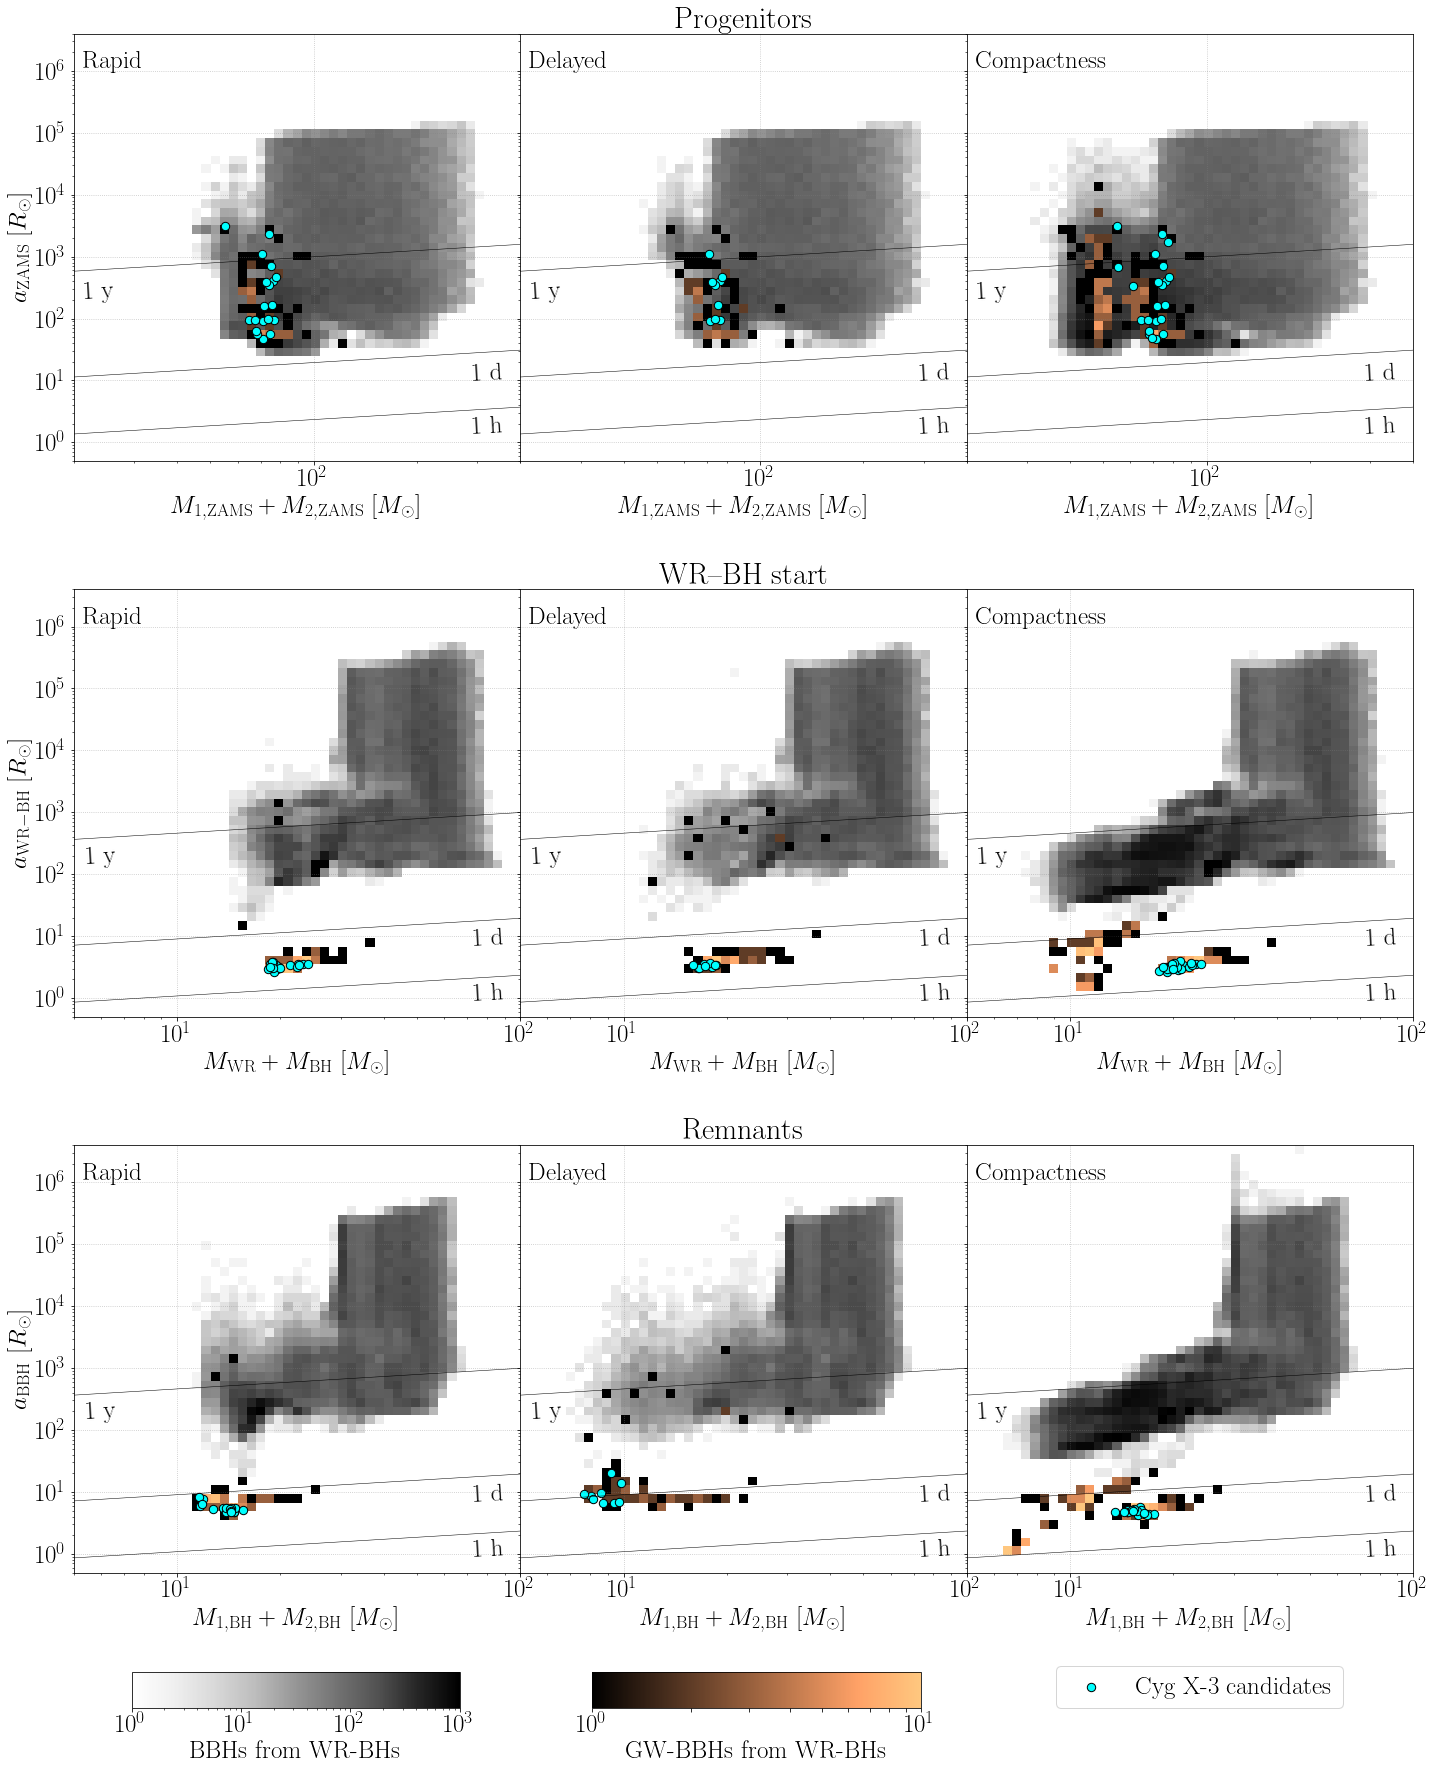

In [12]:
# set parameters
plt.rcParams.update({'text.usetex': True, 
                     'font.family': 'Helvetica', 
                     'font.size': 25})



fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(20,25))
vminall,vmaxall=1,1000
vmingw,vmaxgw =1,10
#x = np.linspace(xmin,xmax,1)
yedges = np.logspace(np.log10(0.5),np.log10(4e6), 50)
Z,kick = '015','unified265'




for SN, SNlabel, icol in zip(SNlist, SNlabels, np.arange(0,len(SNlist))):
    #########################################
    ########  extract dataframes  ###########
    ##########################################
    path_results = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick}/ppisn_{ppisn}'  # path to new folder with all useful results
    
    pall,iall,fall,rall= Extract(dfname0)
    p,i,f,r = Extract(dfname1)
    p2,i2,f2,r2 = Extract(dfname2)

    if ppisn!= 'only':
        dfname = dfname2
        out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname2)
        deltaRLOstableCE = RLOstableCEf - RLOstableCEi
        deltaRLOstable = RLOstablef - RLOstablei

        i_i2, f_f2= Filtername(i,i2), Filtername(f,i2)    # initial and final WRBH time of the cyg x-3
        i_RLOstableCE, f_RLOstableCE = Filtername(i,RLOstableCEi), Filtername(f,RLOstableCEf)  # "" that undergo STABLE
        i_RLOstable, f_RLOstable = Filtername(i,RLOstablei), Filtername(f,RLOstablef) # "" that undergo UNSTABLE

        # deltas of the first dataframes that undergo also the second condition
        delta_if2 = f2 - i2
        delta_if_if2 = f_f2 - i_i2
        delta_if_RLOstable = f_RLOstable - i_RLOstable
        delta_if_RLOstableCE = f_RLOstableCE - i_RLOstableCE
    else:
        dfname=dfname1

    delta_ifall = fall-iall
    delta_if = f-i

    ########################################
    ####### plot rows #####################
    #######################################
    for irow in np.arange(0,3):
        if irow == 0:
            # progenitor configuration 
            xmin,xmax = 20,400
            xedges = np.logspace(np.log10(xmin),np.log10(xmax), 50)
            
            
            counts, xedg,yedg = np.histogram2d(pall.Mass_0.values + pall.Mass_1.values, pall.a.values, bins= [xedges,yedges])
            h1 = axs[irow][icol].hist2d(pall.Mass_0.values + pall.Mass_1.values, pall.a.values, bins=(xedges,yedges), cmap='Greys',norm=colors.LogNorm(vmin=vminall, vmax=vmaxall))
            counts2, xedg,yedg = np.histogram2d(p.Mass_0.values + p.Mass_1.values, p.a.values, bins= [xedges,yedges])
            h2 = axs[irow][icol].hist2d(p.Mass_0.values + p.Mass_1.values, p.a.values, bins=(xedges,yedges), cmap='copper',norm=colors.LogNorm(vmin=vmingw, vmax=vmaxgw))
            
            axs[irow][icol].scatter(p2.Mass_0.values + p2.Mass_1.values, p2.a.values,color='cyan',ec='k',s=70, label='Cyg X-3 candidates')
            
            axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1.),KeplerA(xmax,0,1.)], color='k', linestyle='solid',lw=0.5) # 1 yr
            axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1./365.),KeplerA(xmax,0,1./365.)], color='k', linestyle='solid',lw=0.5) # 1 day
            axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1./(365.*24.)),KeplerA(xmax,0,1./(365.*24))], color='k', linestyle='solid',lw=0.5) # 1 hour
            axs[irow][icol].annotate('1 y',xy=(21.4,210),rotation=3)
            axs[irow][icol].annotate('1 d', xy=(290,10),rotation=3)
            axs[irow][icol].annotate('1 h',xy=(290,1.4),rotation=3)
            
            axs[irow][icol].set_xlabel(r'$M_{\rm 1,ZAMS} + M_{\rm 2,ZAMS}$ [$M_\odot$]')
          
            
        if irow == 1:
            #intial WRBH
            xmin,xmax = 5,1e2
            xedges = np.logspace(np.log10(xmin),np.log10(xmax), 50)
            
            counts, xedg,yedg = np.histogram2d(iall.Mass_0.values + iall.Mass_1.values, iall.Semimajor.values, bins= [xedges,yedges])
            h1 = axs[irow][icol].hist2d(iall.Mass_0.values + iall.Mass_1.values, iall.Semimajor.values, bins=(xedges,yedges), cmap='Greys',norm=colors.LogNorm(vmin=vminall, vmax=vmaxall))
            counts2, xedg,yedg = np.histogram2d(i.Mass_0.values + i.Mass_1.values, i.Semimajor.values, bins= [xedges,yedges])
            h2 = axs[irow][icol].hist2d(i.Mass_0.values + i.Mass_1.values, i.Semimajor.values, bins=(xedges,yedges), cmap='copper',norm=colors.LogNorm(vmin=vmingw, vmax=vmaxgw))
            
            axs[irow][icol].scatter(i_i2.Mass_0.values + i_i2.Mass_1.values, i_i2.Semimajor.values,color='cyan',ec='k',s=70, label='Cyg X-3 candidates')
            
            axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1.),KeplerA(xmax,0,1.)], color='k', linestyle='solid',lw=0.5) # 1 yr
            axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1./365.),KeplerA(xmax,0,1./365.)], color='k', linestyle='solid',lw=0.5) # 1 day
            axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1./(365.*24.)),KeplerA(xmax,0,1./(365.*24))], color='k', linestyle='solid',lw=0.5) # 1 hour
            axs[irow][icol].annotate('1 y',xy=(5.4,150),rotation=3)
            axs[irow][icol].annotate('1 d', xy=(73,7),rotation=3)
            axs[irow][icol].annotate('1 h',xy=(73,0.9),rotation=3)
            
            axs[irow][icol].set_xlabel(r'$M_{\rm WR} + M_{\rm BH}$ [$M_\odot$]')
        
        if irow ==2:
            #remnants
            xmin,xmax = 5,1e2
            xedges = np.logspace(np.log10(xmin),np.log10(xmax), 50)
            
            counts, xedg,yedg = np.histogram2d(rall.Mass_0.values + rall.Mass_1.values, rall.Semimajor.values, bins= [xedges,yedges])
            h1 = axs[irow][icol].hist2d(rall.Mass_0.values + rall.Mass_1.values, rall.Semimajor.values, bins=(xedges,yedges), cmap='Greys',norm=colors.LogNorm(vmin=vminall, vmax=vmaxall))
            counts2, xedg,yedg = np.histogram2d(r.Mass_0.values + r.Mass_1.values, r.Semimajor.values, bins= [xedges,yedges])
            h2 = axs[irow][icol].hist2d(r.Mass_0.values + r.Mass_1.values, r.Semimajor.values, bins=(xedges,yedges), cmap='copper',norm=colors.LogNorm(vmin=vmingw, vmax=vmaxgw))

            axs[irow][icol].scatter(r2.Mass_0.values + r2.Mass_1.values, r2.Semimajor.values,color='cyan',ec='k',s=70, label='Cyg X-3 candidates')
            
            axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1.),KeplerA(xmax,0,1.)], color='k', linestyle='solid',lw=0.5) # 1 yr
            axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1./365.),KeplerA(xmax,0,1./365.)], color='k', linestyle='solid',lw=0.5) # 1 day
            axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1./(365.*24.)),KeplerA(xmax,0,1./(365.*24))], color='k', linestyle='solid',lw=0.5) # 1 hour
            axs[irow][icol].annotate('1 y',xy=(5.4,150),rotation=3)
            axs[irow][icol].annotate('1 d', xy=(73,7),rotation=3)
            axs[irow][icol].annotate('1 h',xy=(73,0.9),rotation=3)
            
            axs[irow][icol].set_xlabel(r'$M_{\rm 1,BH} + M_{\rm 2,BH}$ [$M_\odot$]')
            
        axs[irow][icol].annotate(SNlabel, (0.02,0.92),xycoords='axes fraction', color='k',ha='left')
        axs[irow][icol].set_xscale('log')
        axs[irow][icol].set_yscale('log')
        axs[irow][icol].grid(color='grey',alpha=0.5, linestyle='dotted')
    


axs[0][0].set_ylabel(r'$a_{\rm ZAMS}$ [$R_\odot$]')
axs[1][0].set_ylabel(r'$a_{\rm WR-BH}$ [$R_\odot$]')
axs[2][0].set_ylabel(r'$a_{\rm BBH}$ [$R_\odot$]')



p0 = axs[2][0].get_position().get_points().flatten()
p1 = axs[2][1].get_position().get_points().flatten()
p2 = axs[2][2].get_position().get_points().flatten()
ax_cbar = fig.add_axes([0.09, 0.05, p0[2]-p0[0], 0.02])
ax_cbar1 = fig.add_axes([0.41, 0.05, p1[2]-p1[0], 0.02])

ticklabels = [r'$10^0$','','','','','','','','','$10^1$']
ticks = [1,2,3,4,5,6,7,8,9,10]
fig.colorbar(h1[3], cax=ax_cbar,label='BBHs from WR-BHs', orientation='horizontal')
cbar = fig.colorbar(h2[3], cax=ax_cbar1, label='GW-BBHs from WR-BHs',orientation='horizontal',ticks=ticks)
cbar.ax.set_xticklabels(ticklabels)
cbar.ax.minorticks_off()



handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.94,0.08))   


grid = plt.GridSpec(3,3)
create_subtitle(fig, grid[0, ::], 'Progenitors')
create_subtitle(fig, grid[1, ::], r'WR--BH start')
create_subtitle(fig, grid[2, ::], 'Remnants')
plt.subplots_adjust(top=0.98, left=0.05,right=0.98,wspace=0, hspace=0.3)
#plt.tight_layout()
plt.show()
fig.savefig(f'{path_plots}/binary_{kick}_{Z}.pdf')

del hobbspure265


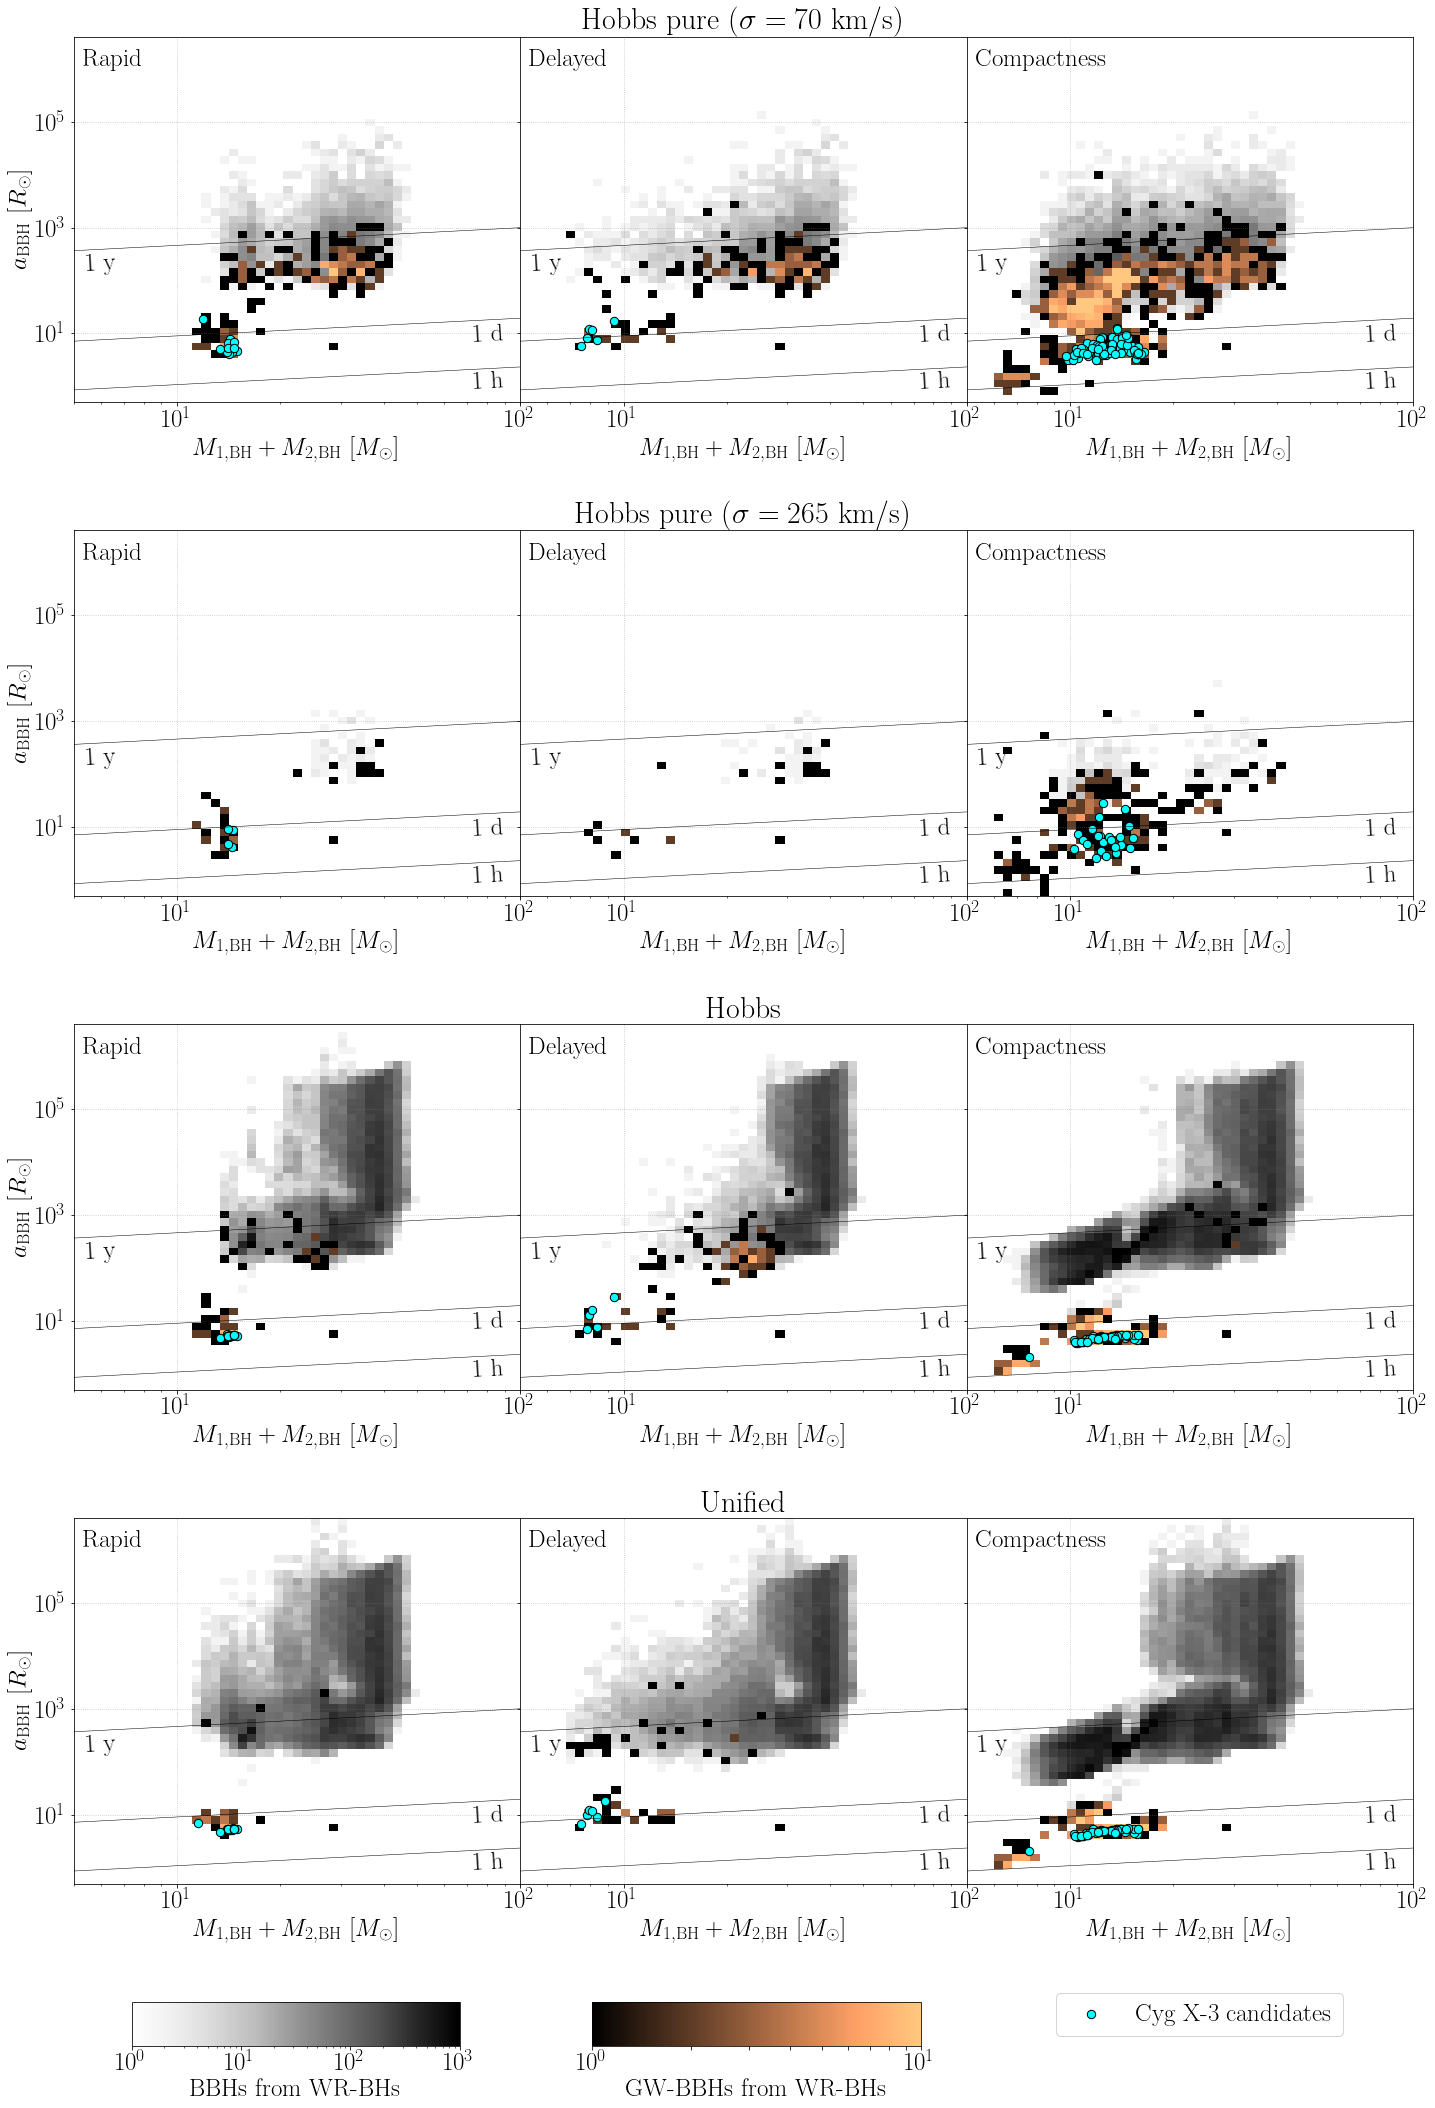

In [14]:
# set parameters
plt.rcParams.update({'text.usetex': True, 
                     'font.family': 'Helvetica', 
                     'font.size': 25})


fig, axs = plt.subplots(nrows=4, ncols=3, sharey=True, figsize=(20,30))
vminall,vmaxall=1,1000
vmingw,vmaxgw =1,10
#x = np.linspace(xmin,xmax,1)
xmin,xmax = 5,100
xedges = np.logspace(np.log10(xmin),np.log10(xmax), 50)
yedges = np.logspace(np.log10(0.5),np.log10(4e6), 50)
Z = '02'




for SN, SNlabel, icol in zip(SNlist, SNlabels, np.arange(0,len(SNlist))):
    for kick, irow in zip(kicklist, np.arange(0,len(kicklist))):
        #########################################
        ########  extract dataframes  ###########
        ##########################################
        path_results = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick}/ppisn_{ppisn}'  # path to new folder with all useful results

        
        pall,iall,fall,rall= Extract(dfname0)
        p,i,f,r = Extract(dfname1)
        
        if (SN== 'del') & (kick =='hobbspure265'):   
            cols = ['Mass_0','Mass_1','name','Semimajor']
            p2,i2,f2,r2 = pd.DataFrame(columns=cols),pd.DataFrame(columns=cols),pd.DataFrame(columns=cols),pd.DataFrame(columns=cols)

            i_i2, f_f2 = pd.DataFrame(columns=cols),pd.DataFrame(columns=cols)
            print(SN,kick)
        
        
        else:     
            p2,i2,f2,r2 = Extract(dfname2)
            
            if ppisn!= 'only':
                dfname = dfname2
                out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname2)
                deltaRLOstableCE = RLOstableCEf - RLOstableCEi
                deltaRLOstable = RLOstablef - RLOstablei

                i_i2, f_f2= Filtername(i,i2), Filtername(f,i2)    # initial and final WRBH time of the cyg x-3
                i_RLOstableCE, f_RLOstableCE = Filtername(i,RLOstableCEi), Filtername(f,RLOstableCEf)  # "" that undergo STABLE
                i_RLOstable, f_RLOstable = Filtername(i,RLOstablei), Filtername(f,RLOstablef) # "" that undergo UNSTABLE

                # deltas of the first dataframes that undergo also the second condition
                delta_if2 = f2 - i2
                delta_if_if2 = f_f2 - i_i2
                delta_if_RLOstable = f_RLOstable - i_RLOstable
                delta_if_RLOstableCE = f_RLOstableCE - i_RLOstableCE
                
                delta_ifall = fall-iall
                delta_if = f-i
            else:
                dfname=dfname1





        ############ plot ################
        
        
        #remnants
        counts, xedg,yedg = np.histogram2d(rall.Mass_0.values + rall.Mass_1.values, rall.Semimajor.values, bins= [xedges,yedges])
        h1 = axs[irow][icol].hist2d(rall.Mass_0.values + rall.Mass_1.values, rall.Semimajor.values, bins=(xedges,yedges), cmap='Greys',norm=colors.LogNorm(vmin=vminall, vmax=vmaxall))
        counts2, xedg,yedg = np.histogram2d(r.Mass_0.values + r.Mass_1.values, r.Semimajor.values, bins= [xedges,yedges])
        h2 = axs[irow][icol].hist2d(r.Mass_0.values + r.Mass_1.values, r.Semimajor.values, bins=(xedges,yedges), cmap='copper',norm=colors.LogNorm(vmin=vmingw, vmax=vmaxgw))

        axs[irow][icol].scatter(r2.Mass_0.values + r2.Mass_1.values, r2.Semimajor.values,color='cyan',ec='k',s=70, label='Cyg X-3 candidates')

        axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1.),KeplerA(xmax,0,1.)], color='k', linestyle='solid',lw=0.5) # 1 yr
        axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1./365.),KeplerA(xmax,0,1./365.)], color='k', linestyle='solid',lw=0.5) # 1 day
        axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1./(365.*24.)),KeplerA(xmax,0,1./(365.*24))], color='k', linestyle='solid',lw=0.5) # 1 hour
        axs[irow][icol].annotate('1 y',xy=(5.4,150),rotation=3)
        axs[irow][icol].annotate('1 d', xy=(73,7),rotation=3)
        axs[irow][icol].annotate('1 h',xy=(73,0.9),rotation=3)

        axs[irow][icol].set_xlabel(r'$M_{\rm 1,BH} + M_{\rm 2,BH}$ [$M_\odot$]')

        axs[irow][icol].annotate(SNlabel, (0.02,0.92),xycoords='axes fraction', color='k',ha='left')
        axs[irow][icol].set_xscale('log')
        axs[irow][icol].set_yscale('log')
        axs[irow][icol].grid(color='grey',alpha=0.5, linestyle='dotted')
    


axs[0][0].set_ylabel(r'$a_{\rm BBH}$ [$R_\odot$]')
axs[1][0].set_ylabel(r'$a_{\rm BBH}$ [$R_\odot$]')
axs[2][0].set_ylabel(r'$a_{\rm BBH}$ [$R_\odot$]')
axs[3][0].set_ylabel(r'$a_{\rm BBH}$ [$R_\odot$]')



p0 = axs[2][0].get_position().get_points().flatten()
p1 = axs[2][1].get_position().get_points().flatten()
p2 = axs[2][2].get_position().get_points().flatten()
ax_cbar = fig.add_axes([0.09, 0.05, p0[2]-p0[0], 0.02])
ax_cbar1 = fig.add_axes([0.41, 0.05, p1[2]-p1[0], 0.02])

ticklabels = [r'$10^0$','','','','','','','','','$10^1$']
ticks = [1,2,3,4,5,6,7,8,9,10]
fig.colorbar(h1[3], cax=ax_cbar,label='BBHs from WR-BHs', orientation='horizontal')
cbar = fig.colorbar(h2[3], cax=ax_cbar1, label='GW-BBHs from WR-BHs',orientation='horizontal',ticks=ticks)
cbar.ax.set_xticklabels(ticklabels)
cbar.ax.minorticks_off()



handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.94,0.08))   


grid = plt.GridSpec(4,3)
create_subtitle(fig, grid[0, ::], kicklabels[0])
create_subtitle(fig, grid[1, ::], kicklabels[1])
create_subtitle(fig, grid[2, ::], kicklabels[2])
create_subtitle(fig, grid[3, ::], kicklabels[3])
plt.subplots_adjust(top=0.98, left=0.05,right=0.98,wspace=0, hspace=0.35)
#plt.tight_layout()
plt.show()
fig.savefig(f'{path_plots}/kickcompare_rem_{Z}.pdf')

# kick compare

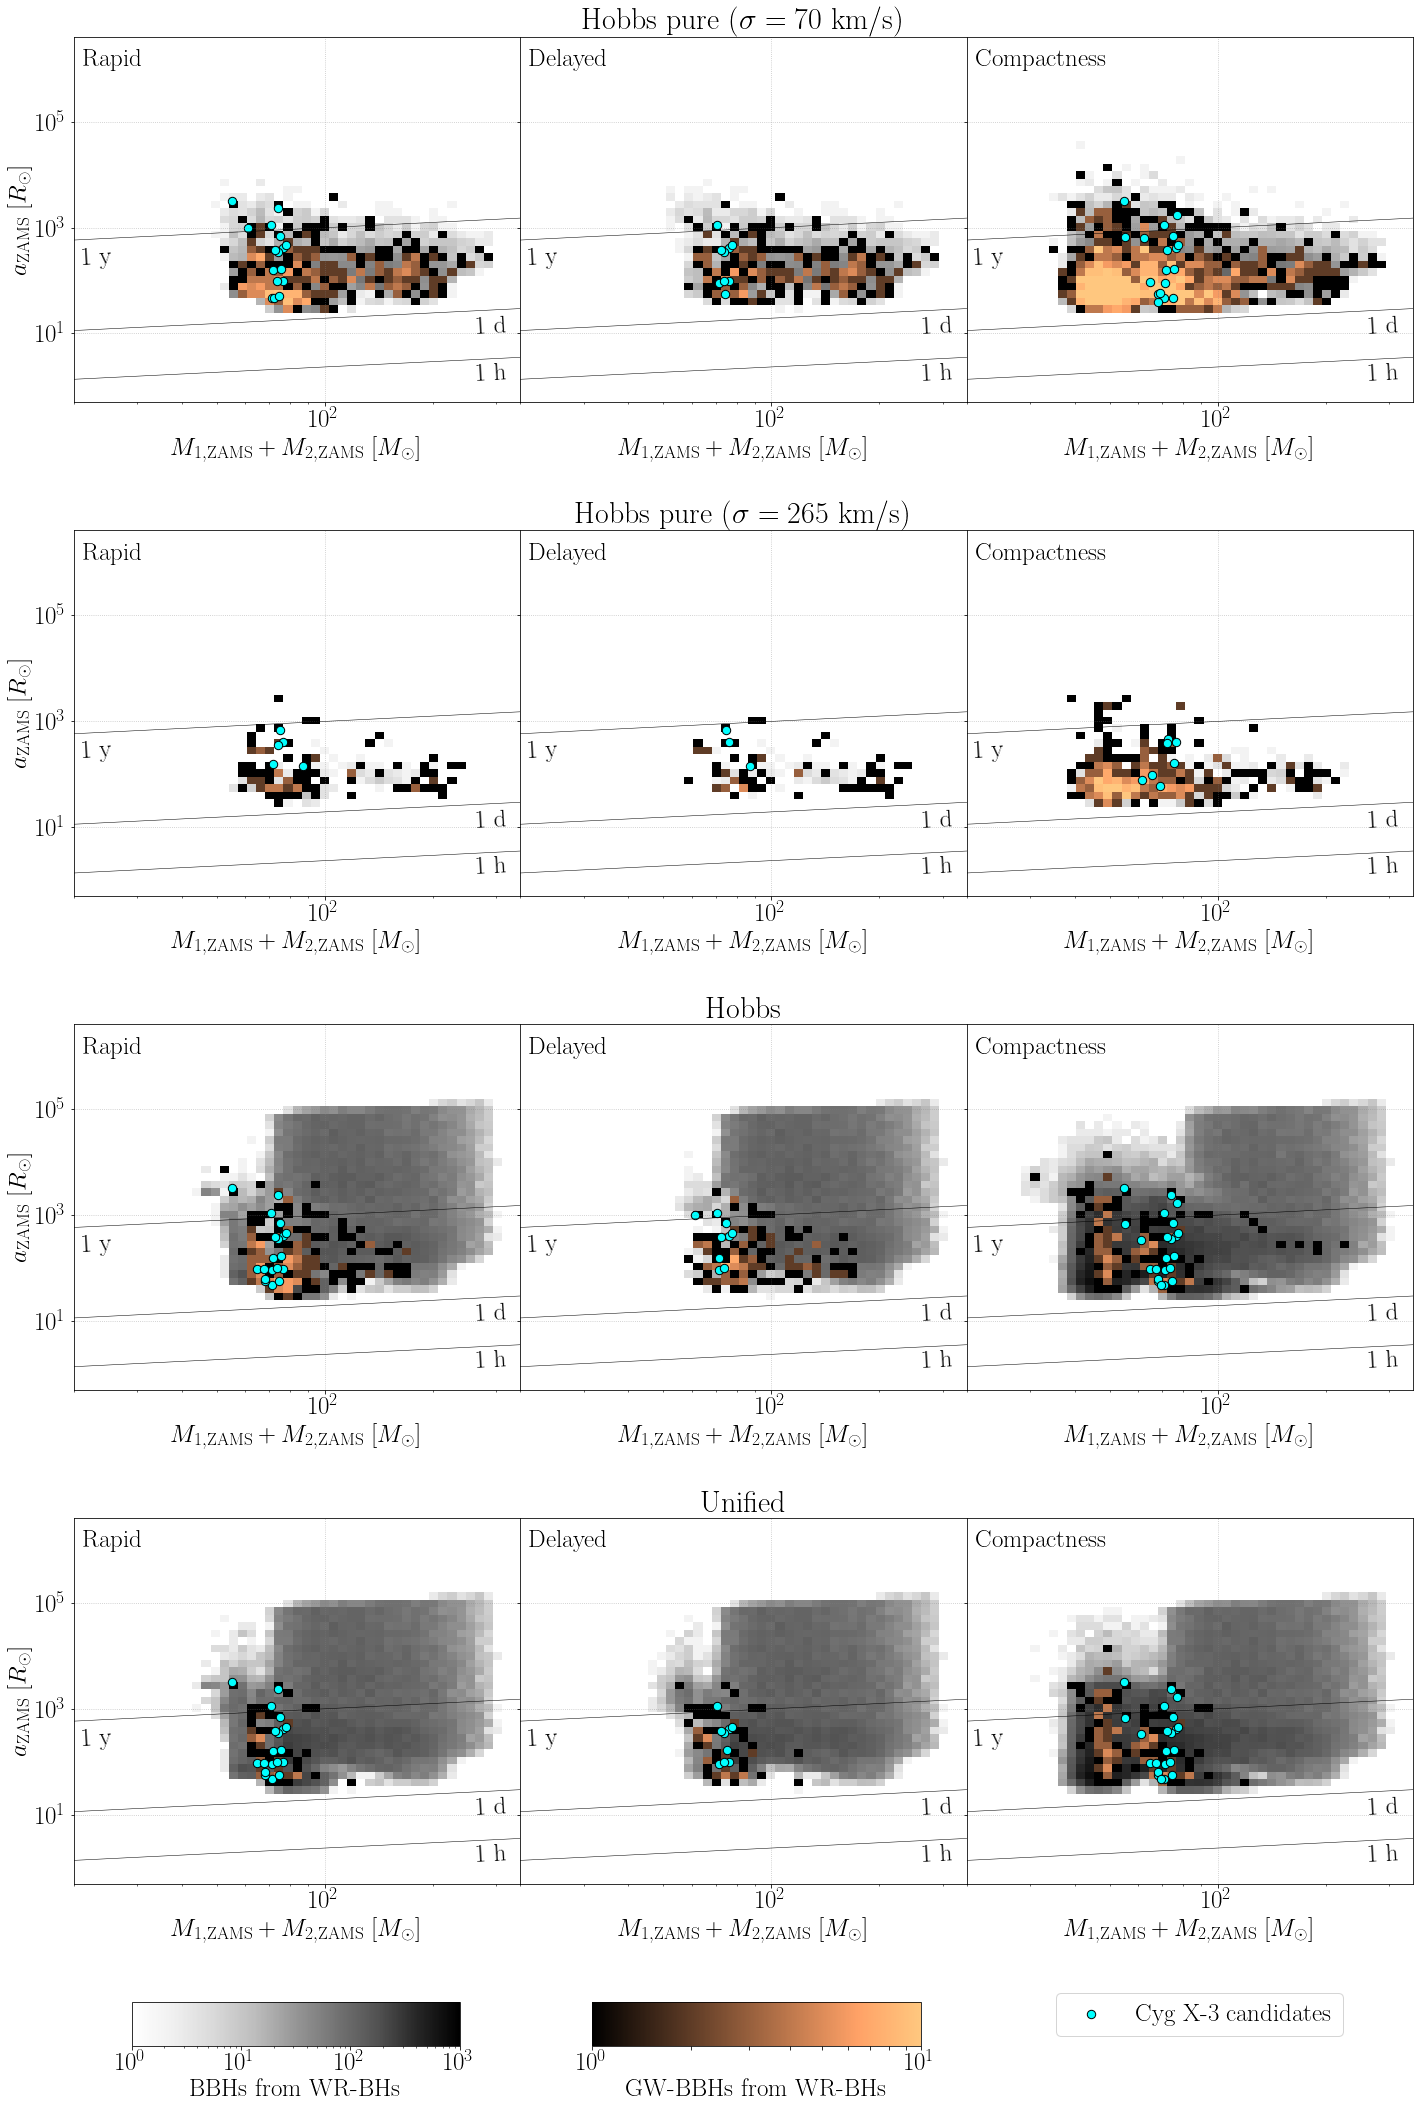

In [15]:
# set parameters
plt.rcParams.update({'text.usetex': True, 
                     'font.family': 'Helvetica', 
                     'font.size': 25})


fig, axs = plt.subplots(nrows=4, ncols=3, sharey=True, figsize=(20,30))
vminall,vmaxall=1,1000
vmingw,vmaxgw =1,10
#x = np.linspace(xmin,xmax,1)
xmin,xmax = 20,350
xedges = np.logspace(np.log10(xmin),np.log10(xmax), 50)
yedges = np.logspace(np.log10(0.5),np.log10(4e6), 50)
Z = '015'




for SN, SNlabel, icol in zip(SNlist, SNlabels, np.arange(0,len(SNlist))):
    for kick, irow in zip(kicklist, np.arange(0,len(kicklist))):
        #########################################
        ########  extract dataframes  ###########
        ##########################################
        path_results = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick}/ppisn_{ppisn}'  # path to new folder with all useful results
        
        pall,iall,fall,rall= Extract(dfname0)
        p,i,f,r = Extract(dfname1)
        p2,i2,f2,r2 = Extract(dfname2)

        if ppisn!= 'only':
            dfname = dfname2
            out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname2)
            deltaRLOstableCE = RLOstableCEf - RLOstableCEi
            deltaRLOstable = RLOstablef - RLOstablei

            i_i2, f_f2= Filtername(i,i2), Filtername(f,i2)    # initial and final WRBH time of the cyg x-3
            i_RLOstableCE, f_RLOstableCE = Filtername(i,RLOstableCEi), Filtername(f,RLOstableCEf)  # "" that undergo STABLE
            i_RLOstable, f_RLOstable = Filtername(i,RLOstablei), Filtername(f,RLOstablef) # "" that undergo UNSTABLE

            # deltas of the first dataframes that undergo also the second condition
            delta_if2 = f2 - i2
            delta_if_if2 = f_f2 - i_i2
            delta_if_RLOstable = f_RLOstable - i_RLOstable
            delta_if_RLOstableCE = f_RLOstableCE - i_RLOstableCE
        else:
            dfname=dfname1

        delta_ifall = fall-iall
        delta_if = f-i


        ############ plot ################
        
        
        #remnants
        counts, xedg,yedg = np.histogram2d(pall.Mass_0.values + pall.Mass_1.values, pall.a.values, bins= [xedges,yedges])
        h1 = axs[irow][icol].hist2d(pall.Mass_0.values + pall.Mass_1.values, pall.a.values, bins=(xedges,yedges), cmap='Greys',norm=colors.LogNorm(vmin=vminall, vmax=vmaxall))
        counts2, xedg,yedg = np.histogram2d(p.Mass_0.values + p.Mass_1.values, p.a.values, bins= [xedges,yedges])
        h2 = axs[irow][icol].hist2d(p.Mass_0.values + p.Mass_1.values, p.a.values, bins=(xedges,yedges), cmap='copper',norm=colors.LogNorm(vmin=vmingw, vmax=vmaxgw))

        axs[irow][icol].scatter(p2.Mass_0.values + p2.Mass_1.values, p2.a.values,color='cyan',ec='k',s=70, label='Cyg X-3 candidates')

        axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1.),KeplerA(xmax,0,1.)], color='k', linestyle='solid',lw=0.5) # 1 yr
        axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1./365.),KeplerA(xmax,0,1./365.)], color='k', linestyle='solid',lw=0.5) # 1 day
        axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1./(365.*24.)),KeplerA(xmax,0,1./(365.*24))], color='k', linestyle='solid',lw=0.5) # 1 hour
        axs[irow][icol].annotate('1 y',xy=(21.,200),rotation=3)
        axs[irow][icol].annotate('1 d', xy=(263,10),rotation=3)
        axs[irow][icol].annotate('1 h',xy=(263,1.3),rotation=3)

        axs[irow][icol].set_xlabel(r'$M_{\rm 1,ZAMS} + M_{\rm 2,ZAMS}$ [$M_\odot$]')

        axs[irow][icol].annotate(SNlabel, (0.02,0.92),xycoords='axes fraction', color='k',ha='left')
        axs[irow][icol].set_xscale('log')
        axs[irow][icol].set_yscale('log')
        axs[irow][icol].grid(color='grey',alpha=0.5, linestyle='dotted')
    


axs[0][0].set_ylabel(r'$a_{\rm ZAMS}$ [$R_\odot$]')
axs[1][0].set_ylabel(r'$a_{\rm ZAMS}$ [$R_\odot$]')
axs[2][0].set_ylabel(r'$a_{\rm ZAMS}$ [$R_\odot$]')
axs[3][0].set_ylabel(r'$a_{\rm ZAMS}$ [$R_\odot$]')



p0 = axs[2][0].get_position().get_points().flatten()
p1 = axs[2][1].get_position().get_points().flatten()
p2 = axs[2][2].get_position().get_points().flatten()
ax_cbar = fig.add_axes([0.09, 0.05, p0[2]-p0[0], 0.02])
ax_cbar1 = fig.add_axes([0.41, 0.05, p1[2]-p1[0], 0.02])

ticklabels = [r'$10^0$','','','','','','','','','$10^1$']
ticks = [1,2,3,4,5,6,7,8,9,10]
fig.colorbar(h1[3], cax=ax_cbar,label='BBHs from WR-BHs', orientation='horizontal')
cbar = fig.colorbar(h2[3], cax=ax_cbar1, label='GW-BBHs from WR-BHs',orientation='horizontal',ticks=ticks)
cbar.ax.set_xticklabels(ticklabels)
cbar.ax.minorticks_off()



handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.94,0.08))   


grid = plt.GridSpec(4,3)
create_subtitle(fig, grid[0, ::], kicklabels[0])
create_subtitle(fig, grid[1, ::], kicklabels[1])
create_subtitle(fig, grid[2, ::], kicklabels[2])
create_subtitle(fig, grid[3, ::], kicklabels[3])
plt.subplots_adjust(top=0.98, left=0.05,right=0.98,wspace=0, hspace=0.35)
#plt.tight_layout()
plt.show()
fig.savefig(f'{path_plots}/kickcompare_prog_{Z}.pdf')

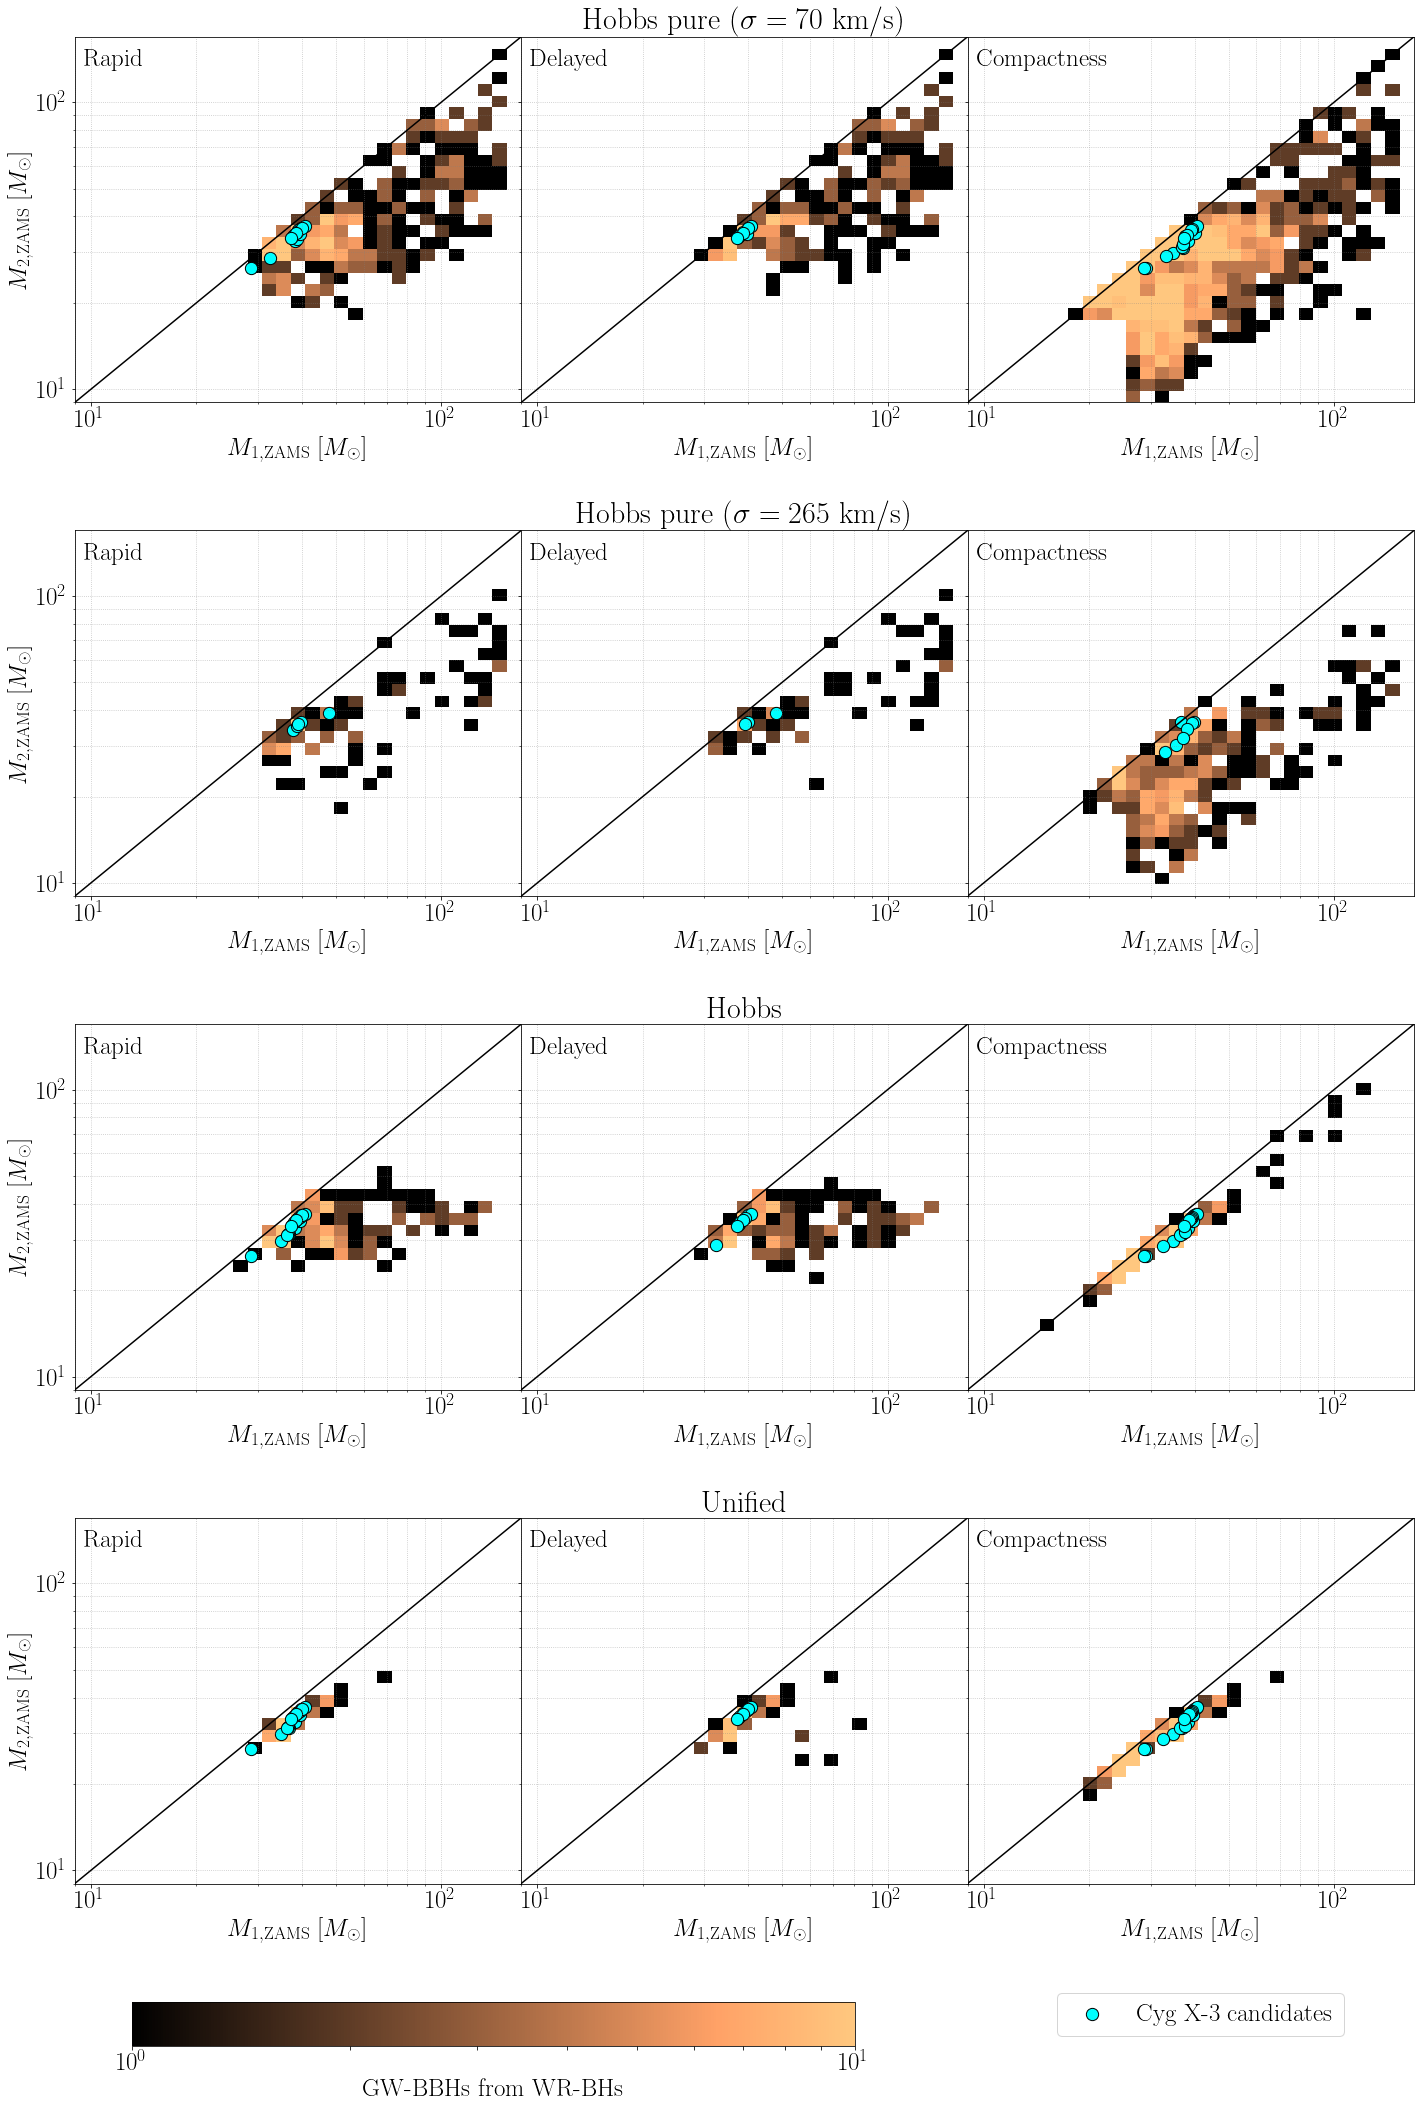

In [16]:
# set parameters
plt.rcParams.update({'text.usetex': True, 
                     'font.family': 'Helvetica', 
                     'font.size': 25})


fig, axs = plt.subplots(nrows=4, ncols=3, sharey=True, figsize=(20,30))
vminall,vmaxall=1,1000
vmingw,vmaxgw =1,10
#x = np.linspace(xmin,xmax,1)
xmin,xmax = 9,169
xedges = np.logspace(np.log10(xmin),np.log10(xmax), 32) # 5 msun bin width
yedges = np.logspace(np.log10(xmin),np.log10(xmax), 32)
Z = '015'




for SN, SNlabel, icol in zip(SNlist, SNlabels, np.arange(0,len(SNlist))):
    for kick, irow in zip(kicklist, np.arange(0,len(kicklist))):
        #########################################
        ########  extract dataframes  ###########
        ##########################################
        path_results = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick}/ppisn_{ppisn}'  # path to new folder with all useful results
        
        pall,iall,fall,rall= Extract(dfname0)
        p,i,f,r = Extract(dfname1)
        p2,i2,f2,r2 = Extract(dfname2)

        if ppisn!= 'only':
            dfname = dfname2
            out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname2)
            deltaRLOstableCE = RLOstableCEf - RLOstableCEi
            deltaRLOstable = RLOstablef - RLOstablei

            i_i2, f_f2= Filtername(i,i2), Filtername(f,i2)    # initial and final WRBH time of the cyg x-3
            i_RLOstableCE, f_RLOstableCE = Filtername(i,RLOstableCEi), Filtername(f,RLOstableCEf)  # "" that undergo STABLE
            i_RLOstable, f_RLOstable = Filtername(i,RLOstablei), Filtername(f,RLOstablef) # "" that undergo UNSTABLE

            # deltas of the first dataframes that undergo also the second condition
            delta_if2 = f2 - i2
            delta_if_if2 = f_f2 - i_i2
            delta_if_RLOstable = f_RLOstable - i_RLOstable
            delta_if_RLOstableCE = f_RLOstableCE - i_RLOstableCE
        else:
            dfname=dfname1

        delta_ifall = fall-iall
        delta_if = f-i


        ############ plot ################
        
        
        #remnants
        #counts, xedg,yedg = np.histogram2d(pall.Mass_0.values, pall.Mass_1.values, bins= [xedges,yedges])
        #h1 = axs[irow][icol].hist2d(pall.Mass_0.values, pall.Mass_1.values, bins=(xedges,yedges), cmap='Greys',norm=colors.LogNorm(vmin=vminall, vmax=vmaxall))
        counts2, xedg,yedg = np.histogram2d(p.Mass_0.values, p.Mass_1.values, bins= [xedges,yedges])
        h2 = axs[irow][icol].hist2d(p.Mass_0.values, p.Mass_1.values,  bins=(xedges,yedges), cmap='copper',norm=colors.LogNorm(vmin=vmingw, vmax=vmaxgw))

        axs[irow][icol].scatter(p2.Mass_0.values, p2.Mass_1.values, color='cyan',ec='k',s=150, label='Cyg X-3 candidates')
        axs[irow][icol].plot([xmin,xmax],[xmin,xmax],color='k',linestyle='solid')
        
        axs[irow][icol].set_xlabel(r'$M_{\rm 1, ZAMS}$ [$M_\odot$]')
        axs[irow][icol].set_xticks(np.arange(xmin,xmax,10))

        axs[irow][icol].annotate(SNlabel, (0.02,0.92),xycoords='axes fraction', color='k',ha='left')
        axs[irow][icol].set_xscale('log')
        axs[irow][icol].set_yscale('log')
        axs[irow][icol].grid(color='grey',alpha=0.5, which='both',linestyle='dotted')
    


axs[0][0].set_ylabel(r'$M_{\rm 2,ZAMS}$ [$M_\odot$]')
axs[1][0].set_ylabel(r'$M_{\rm 2,ZAMS}$ [$M_\odot$]')
axs[2][0].set_ylabel(r'$M_{\rm 2,ZAMS}$ [$M_\odot$]')
axs[3][0].set_ylabel(r'$M_{\rm 2,ZAMS}$ [$M_\odot$]')



p0 = axs[2][0].get_position().get_points().flatten()
p1 = axs[2][1].get_position().get_points().flatten()
p2 = axs[2][2].get_position().get_points().flatten()
#ax_cbar = fig.add_axes([0.09, 0.05, p0[2]-p0[0], 0.02])
ax_cbar1 = fig.add_axes([0.09, 0.05, p1[2]-p0[0], 0.02])

ticklabels = [r'$10^0$','','','','','','','','','$10^1$']
ticks = [1,2,3,4,5,6,7,8,9,10]
#fig.colorbar(h1[3], cax=ax_cbar,label='BBHs from WR-BHs', orientation='horizontal')
cbar = fig.colorbar(h2[3], cax=ax_cbar1, label='GW-BBHs from WR-BHs',orientation='horizontal',ticks=ticks)
cbar.ax.set_xticklabels(ticklabels)
cbar.ax.minorticks_off()



handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.94,0.08))   


grid = plt.GridSpec(4,3)
create_subtitle(fig, grid[0, ::], kicklabels[0])
create_subtitle(fig, grid[1, ::], kicklabels[1])
create_subtitle(fig, grid[2, ::], kicklabels[2])
create_subtitle(fig, grid[3, ::], kicklabels[3])
plt.subplots_adjust(top=0.98, left=0.05,right=0.98,wspace=0, hspace=0.35)
#plt.tight_layout()
plt.show()
fig.savefig(f'{path_plots}/kickcompare_progM1M2_{Z}.pdf')

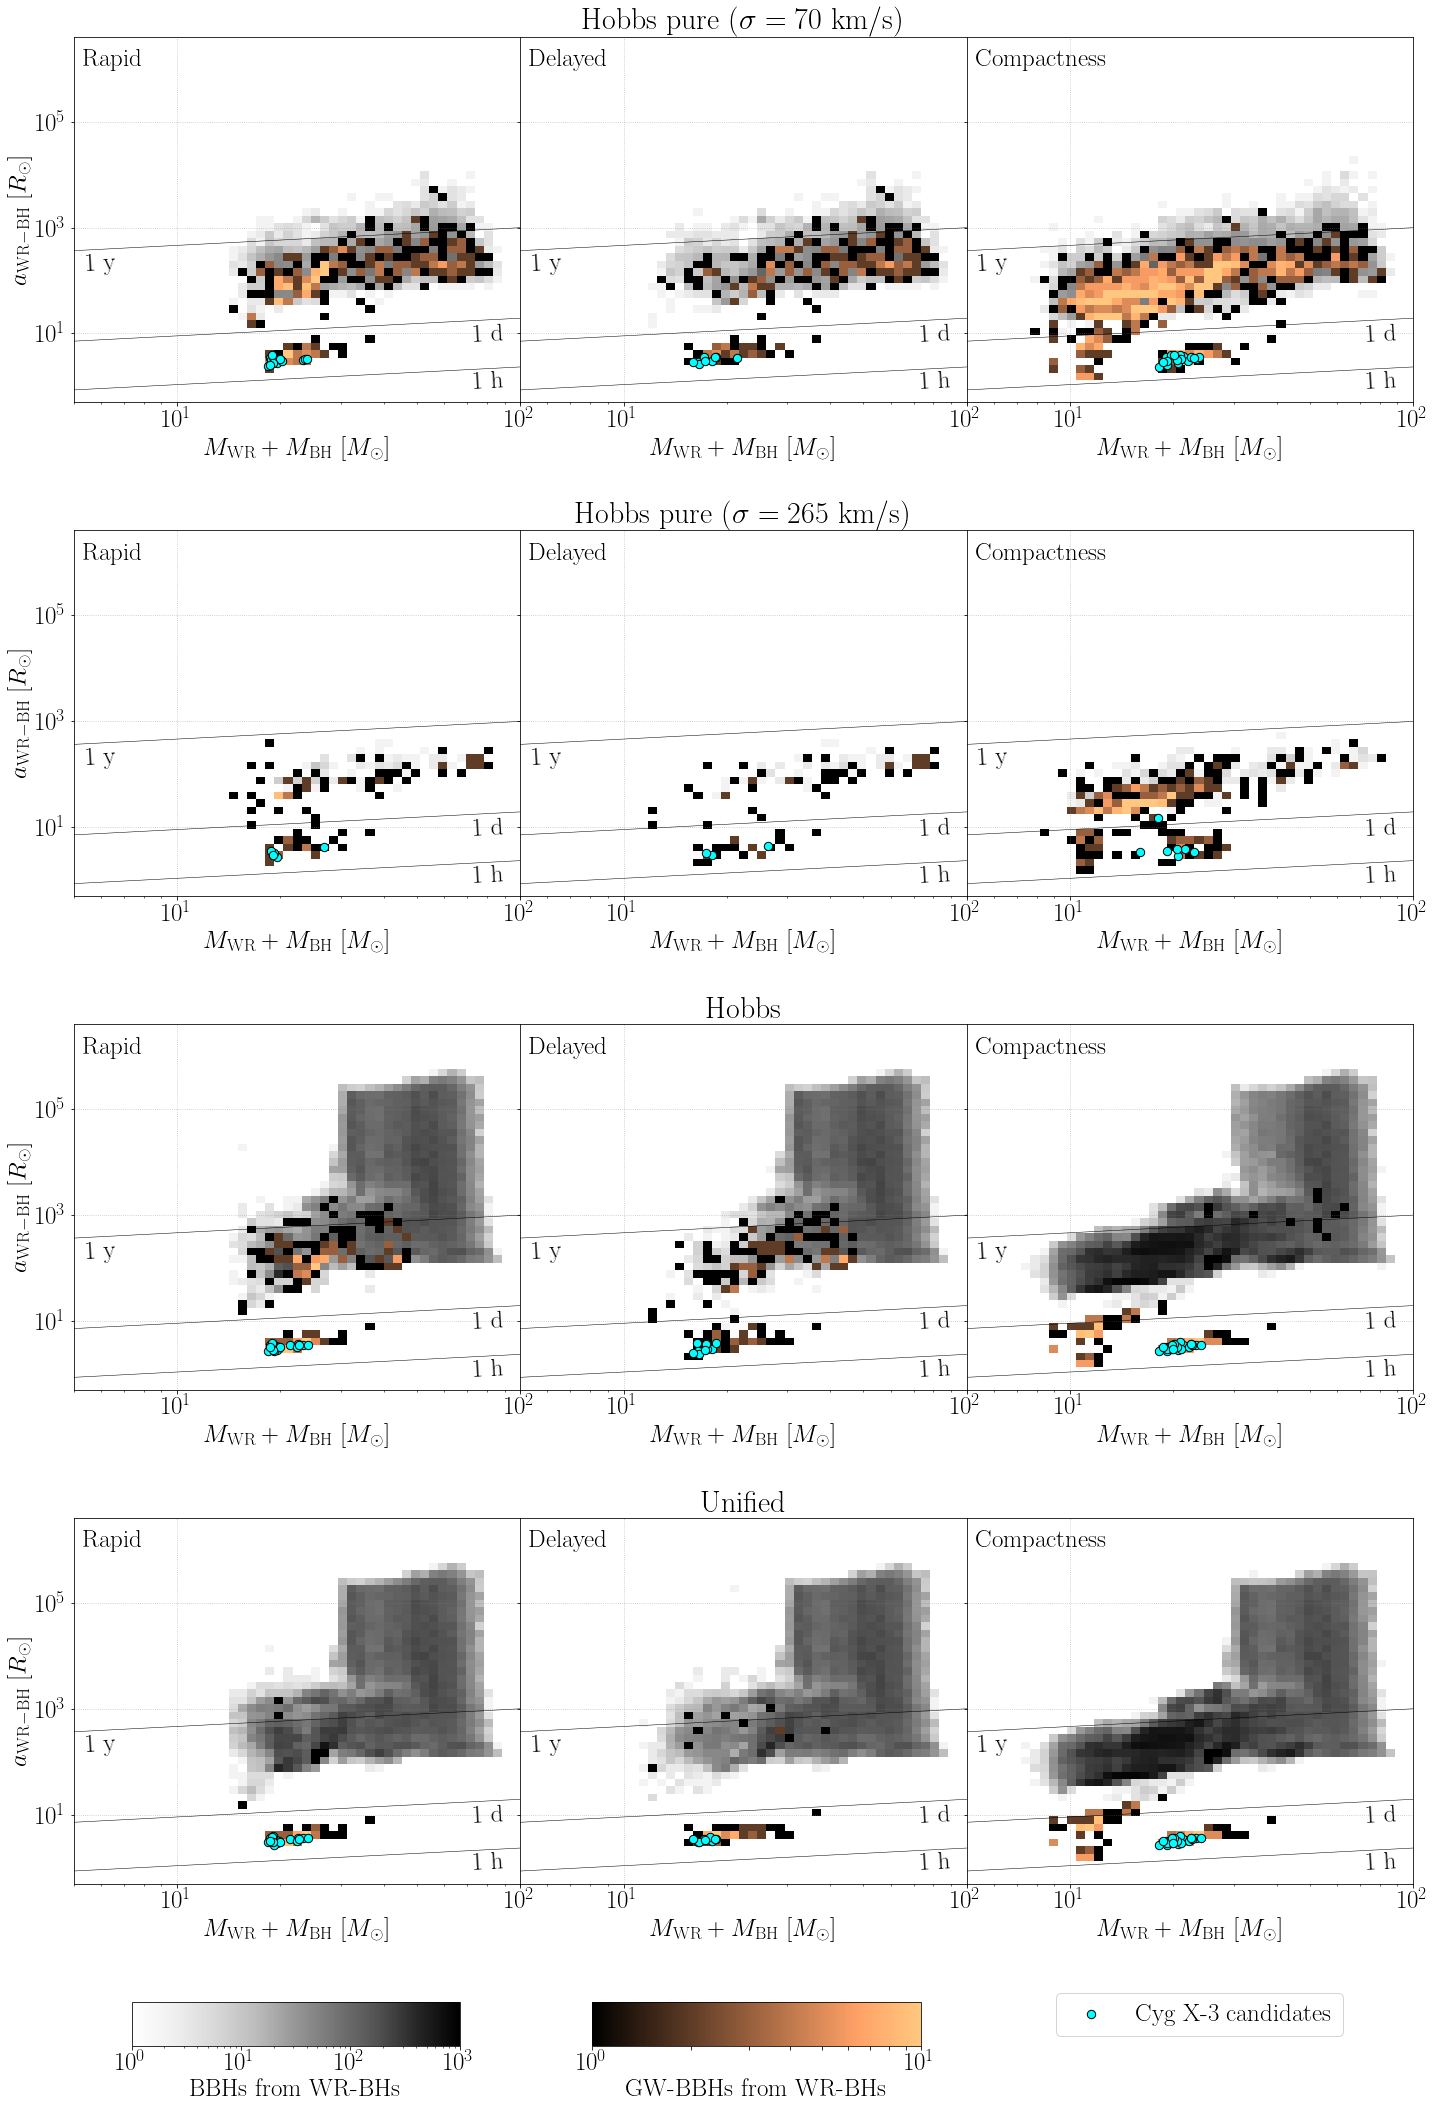

In [17]:
# set parameters
plt.rcParams.update({'text.usetex': True, 
                     'font.family': 'Helvetica', 
                     'font.size': 25})


fig, axs = plt.subplots(nrows=4, ncols=3, sharey=True, figsize=(20,30))
vminall,vmaxall=1,1000
vmingw,vmaxgw =1,10
#x = np.linspace(xmin,xmax,1)
xmin,xmax = 5,1e2
xedges = np.logspace(np.log10(xmin),np.log10(xmax), 50)
yedges = np.logspace(np.log10(0.5),np.log10(4e6), 50)
Z = '015'




for SN, SNlabel, icol in zip(SNlist, SNlabels, np.arange(0,len(SNlist))):
    for kick, irow in zip(kicklist, np.arange(0,len(kicklist))):
        #########################################
        ########  extract dataframes  ###########
        ##########################################
        path_results = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick}/ppisn_{ppisn}'  # path to new folder with all useful results
        
        pall,iall,fall,rall= Extract(dfname0)
        p,i,f,r = Extract(dfname1)
        p2,i2,f2,r2 = Extract(dfname2)

        if ppisn!= 'only':
            dfname = dfname2
            out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname2)
            deltaRLOstableCE = RLOstableCEf - RLOstableCEi
            deltaRLOstable = RLOstablef - RLOstablei

            i_i2, f_f2= Filtername(i,i2), Filtername(f,i2)    # initial and final WRBH time of the cyg x-3
            i_RLOstableCE, f_RLOstableCE = Filtername(i,RLOstableCEi), Filtername(f,RLOstableCEf)  # "" that undergo STABLE
            i_RLOstable, f_RLOstable = Filtername(i,RLOstablei), Filtername(f,RLOstablef) # "" that undergo UNSTABLE

            # deltas of the first dataframes that undergo also the second condition
            delta_if2 = f2 - i2
            delta_if_if2 = f_f2 - i_i2
            delta_if_RLOstable = f_RLOstable - i_RLOstable
            delta_if_RLOstableCE = f_RLOstableCE - i_RLOstableCE
        else:
            dfname=dfname1

        delta_ifall = fall-iall
        delta_if = f-i


        ############ plot ################
        
        
        #remnants
        counts, xedg,yedg = np.histogram2d(iall.Mass_0.values + iall.Mass_1.values, iall.Semimajor.values, bins= [xedges,yedges])
        h1 = axs[irow][icol].hist2d(iall.Mass_0.values + iall.Mass_1.values, iall.Semimajor.values, bins=(xedges,yedges), cmap='Greys',norm=colors.LogNorm(vmin=vminall, vmax=vmaxall))
        counts2, xedg,yedg = np.histogram2d(i.Mass_0.values + i.Mass_1.values, i.Semimajor.values, bins= [xedges,yedges])
        h2 = axs[irow][icol].hist2d(i.Mass_0.values + i.Mass_1.values, i.Semimajor.values, bins=(xedges,yedges), cmap='copper',norm=colors.LogNorm(vmin=vmingw, vmax=vmaxgw))

        axs[irow][icol].scatter(i_i2.Mass_0.values + i_i2.Mass_1.values, i_i2.Semimajor.values,color='cyan',ec='k',s=70, label='Cyg X-3 candidates')

        axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1.),KeplerA(xmax,0,1.)], color='k', linestyle='solid',lw=0.5) # 1 yr
        axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1./365.),KeplerA(xmax,0,1./365.)], color='k', linestyle='solid',lw=0.5) # 1 day
        axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1./(365.*24.)),KeplerA(xmax,0,1./(365.*24))], color='k', linestyle='solid',lw=0.5) # 1 hour
        axs[irow][icol].annotate('1 y',xy=(5.4,150),rotation=3)
        axs[irow][icol].annotate('1 d', xy=(73,7),rotation=3)
        axs[irow][icol].annotate('1 h',xy=(73,0.9),rotation=3)

        axs[irow][icol].set_xlabel(r'$M_{\rm WR} + M_{\rm BH}$ [$M_\odot$]')

        axs[irow][icol].annotate(SNlabel, (0.02,0.92),xycoords='axes fraction', color='k',ha='left')
        axs[irow][icol].set_xscale('log')
        axs[irow][icol].set_yscale('log')
        axs[irow][icol].grid(color='grey',alpha=0.5, linestyle='dotted')
    


axs[0][0].set_ylabel(r'$a_{\rm WR-BH}$ [$R_\odot$]')
axs[1][0].set_ylabel(r'$a_{\rm WR-BH}$ [$R_\odot$]')
axs[2][0].set_ylabel(r'$a_{\rm WR-BH}$ [$R_\odot$]')
axs[3][0].set_ylabel(r'$a_{\rm WR-BH}$ [$R_\odot$]')



p0 = axs[2][0].get_position().get_points().flatten()
p1 = axs[2][1].get_position().get_points().flatten()
p2 = axs[2][2].get_position().get_points().flatten()
ax_cbar = fig.add_axes([0.09, 0.05, p0[2]-p0[0], 0.02])
ax_cbar1 = fig.add_axes([0.41, 0.05, p1[2]-p1[0], 0.02])

ticklabels = [r'$10^0$','','','','','','','','','$10^1$']
ticks = [1,2,3,4,5,6,7,8,9,10]
fig.colorbar(h1[3], cax=ax_cbar,label='BBHs from WR-BHs', orientation='horizontal')
cbar = fig.colorbar(h2[3], cax=ax_cbar1, label='GW-BBHs from WR-BHs',orientation='horizontal',ticks=ticks)
cbar.ax.set_xticklabels(ticklabels)
cbar.ax.minorticks_off()



handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.94,0.08))   


grid = plt.GridSpec(4,3)
create_subtitle(fig, grid[0, ::], kicklabels[0])
create_subtitle(fig, grid[1, ::], kicklabels[1])
create_subtitle(fig, grid[2, ::], kicklabels[2])
create_subtitle(fig, grid[3, ::], kicklabels[3])
plt.subplots_adjust(top=0.98, left=0.05,right=0.98,wspace=0, hspace=0.35)
#plt.tight_layout()
plt.show()
fig.savefig(f'{path_plots}/kickcompare_WRBH_{Z}.pdf')

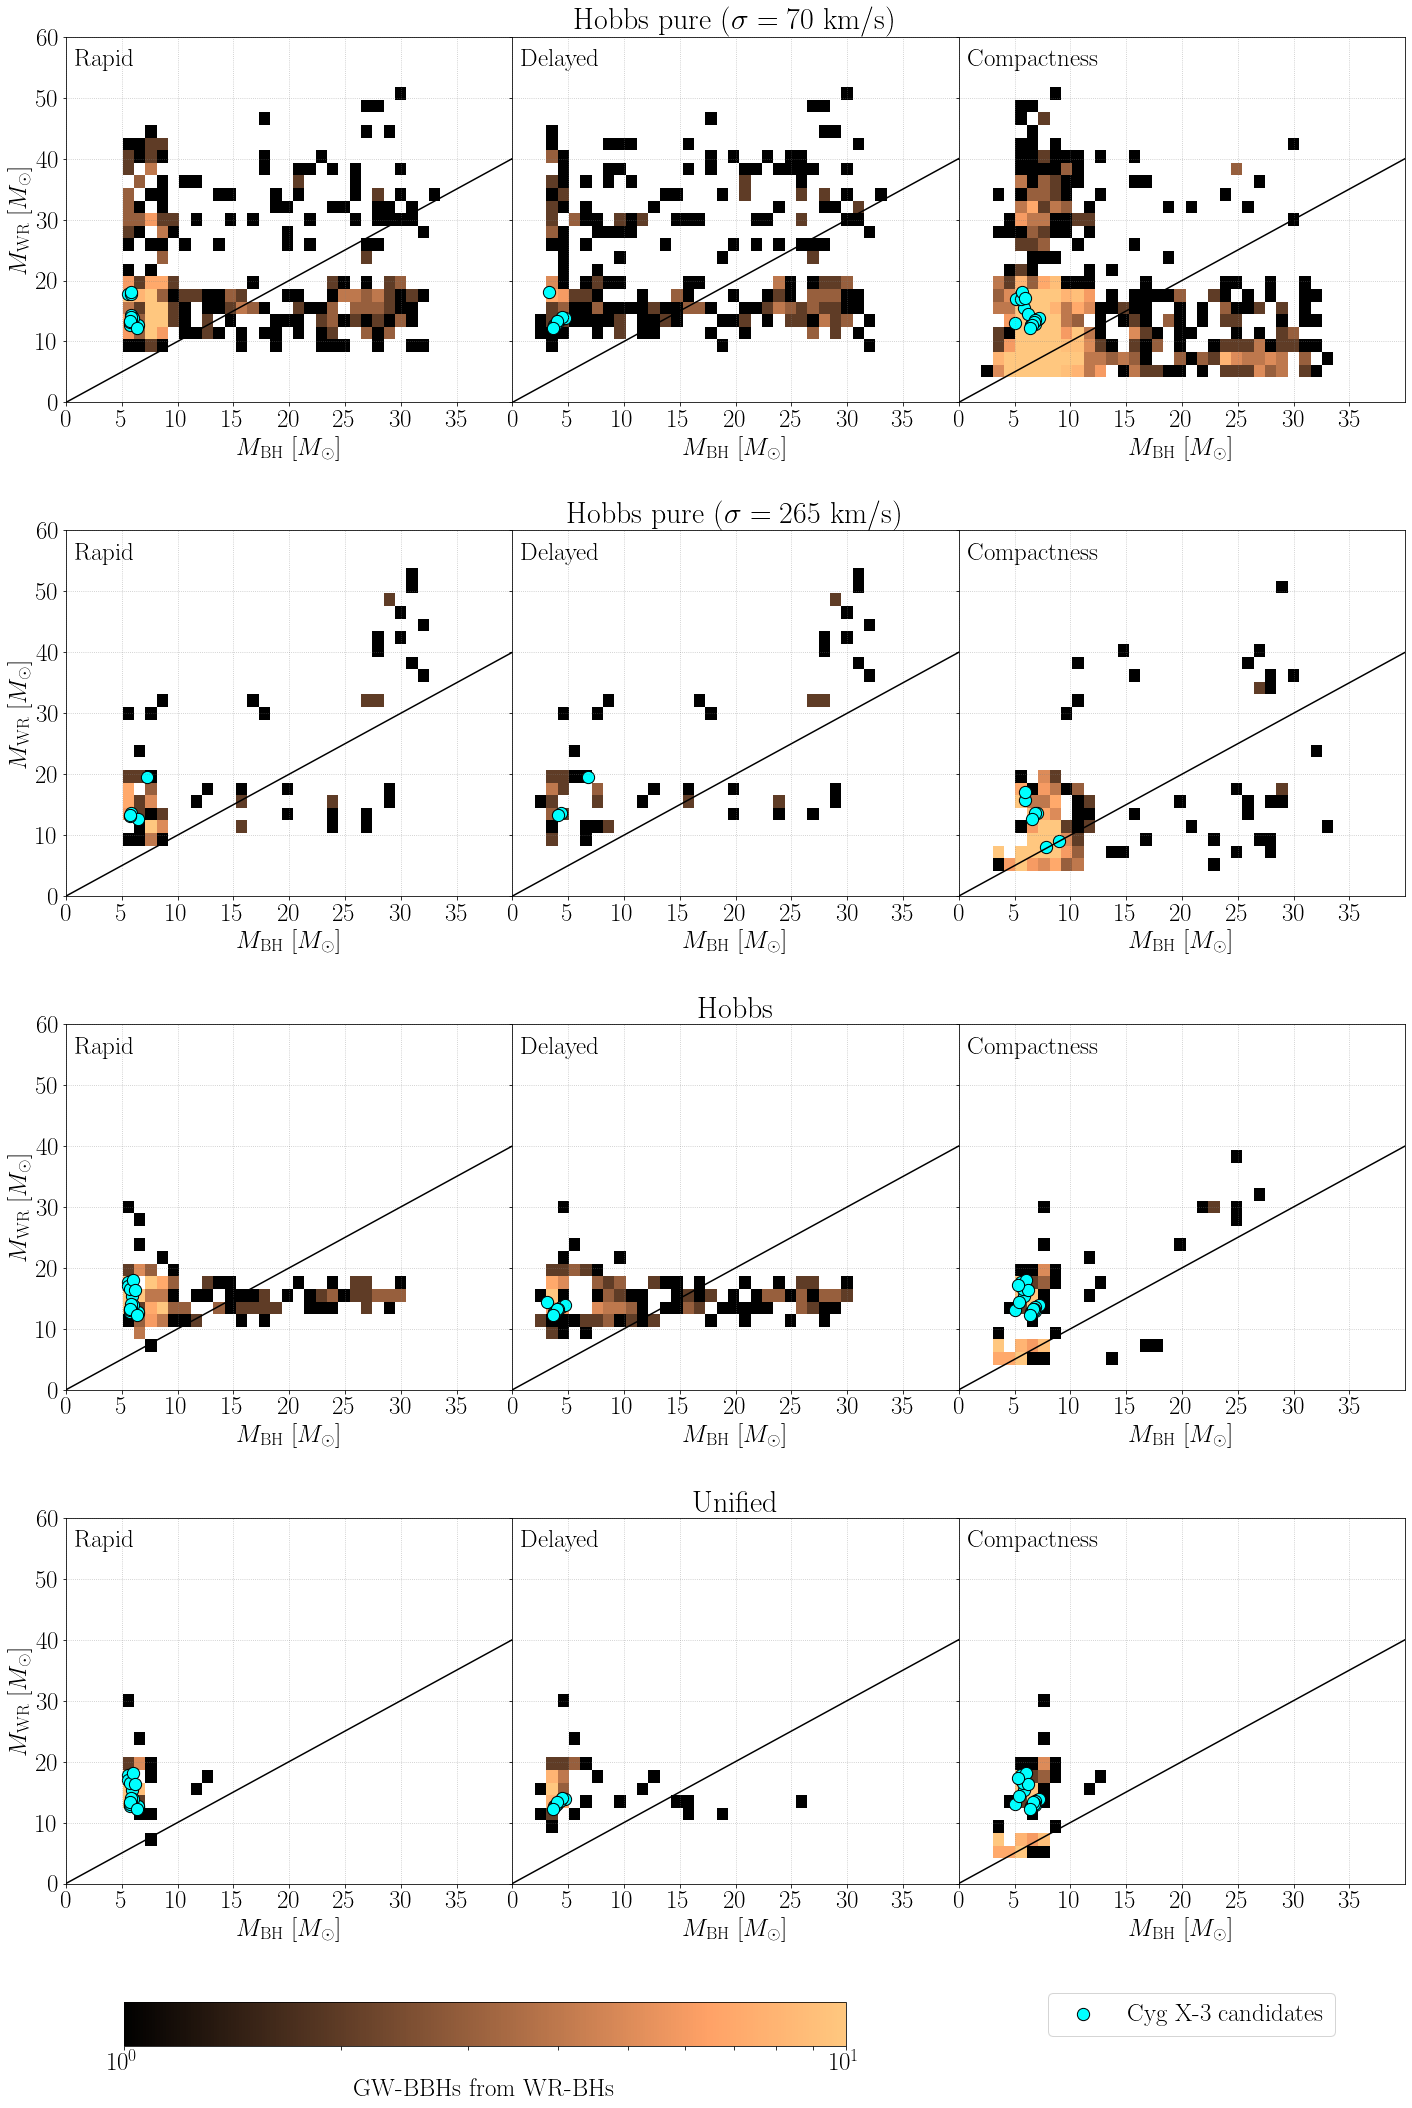

In [18]:
# set parameters
plt.rcParams.update({'text.usetex': True, 
                     'font.family': 'Helvetica', 
                     'font.size': 25})


fig, axs = plt.subplots(nrows=4, ncols=3, sharey=True, figsize=(20,30))
vminall,vmaxall=1,1000
vmingw,vmaxgw =1,10
#x = np.linspace(xmin,xmax,1)
xmin,xmax = 0,60
# xedges = np.logspace(np.log10(xmin),np.log10(xmax), 25) # 2 msun bin width
# yedges = np.logspace(np.log10(xmin),np.log10(xmax), 25)
xedges = np.linspace(xmin,xmax, 60) 
yedges = np.linspace(xmin,xmax, 30)
Z = '015'




for SN, SNlabel, icol in zip(SNlist, SNlabels, np.arange(0,len(SNlist))):
    for kick, irow in zip(kicklist, np.arange(0,len(kicklist))):
        #########################################
        ########  extract dataframes  ###########
        ##########################################
        path_results = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick}/ppisn_{ppisn}'  # path to new folder with all useful results
        
        pall,iall,fall,rall= Extract(dfname0)
        p,i,f,r = Extract(dfname1)
        p2,i2,f2,r2 = Extract(dfname2)

        if ppisn!= 'only':
            dfname = dfname2
            out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname2)
            deltaRLOstableCE = RLOstableCEf - RLOstableCEi
            deltaRLOstable = RLOstablef - RLOstablei

            i_i2, f_f2= Filtername(i,i2), Filtername(f,i2)    # initial and final WRBH time of the cyg x-3
            i_RLOstableCE, f_RLOstableCE = Filtername(i,RLOstableCEi), Filtername(f,RLOstableCEf)  # "" that undergo STABLE
            i_RLOstable, f_RLOstable = Filtername(i,RLOstablei), Filtername(f,RLOstablef) # "" that undergo UNSTABLE

            # deltas of the first dataframes that undergo also the second condition
            delta_if2 = f2 - i2
            delta_if_if2 = f_f2 - i_i2
            delta_if_RLOstable = f_RLOstable - i_RLOstable
            delta_if_RLOstableCE = f_RLOstableCE - i_RLOstableCE
        else:
            dfname=dfname1

        delta_ifall = fall-iall
        delta_if = f-i


        ############ plot ################
        
        iBH = np.concatenate([i.loc[i['PhaseBSE_0'] == 14].Mass_0.values, i.loc[i['PhaseBSE_1'] == 14].Mass_1.values])
        iWR = np.concatenate([i.loc[i['PhaseBSE_0'] != 14].Mass_0.values, i.loc[i['PhaseBSE_1'] != 14].Mass_1.values])
 
        i_i2BH = np.concatenate([i_i2.loc[i_i2['PhaseBSE_0'] == 14].Mass_0.values, i_i2.loc[i_i2['PhaseBSE_1'] == 14].Mass_1.values])
        i_i2WR = np.concatenate([i_i2.loc[i_i2['PhaseBSE_0'] != 14].Mass_0.values, i_i2.loc[i_i2['PhaseBSE_1'] != 14].Mass_1.values])
#         if SN == 'com':
#             print(i.loc[i['PhaseBSE_1'] != 14][['Mass_1','PhaseBSE_1']])

        #remnants
        #counts, xedg,yedg = np.histogram2d(pall.Mass_0.values, pall.Mass_1.values, bins= [xedges,yedges])
        #h1 = axs[irow][icol].hist2d(pall.Mass_0.values, pall.Mass_1.values, bins=(xedges,yedges), cmap='Greys',norm=colors.LogNorm(vmin=vminall, vmax=vmaxall))
        counts2, xedg,yedg = np.histogram2d(iBH, iWR, bins= [xedges,yedges])
        h2 = axs[irow][icol].hist2d(iBH, iWR,  bins=(xedges,yedges), cmap='copper',norm=colors.LogNorm(vmin=vmingw, vmax=vmaxgw))

        axs[irow][icol].scatter(i_i2BH, i_i2WR, color='cyan',ec='k',s=150, label='Cyg X-3 candidates')
        axs[irow][icol].plot([xmin,xmax],[xmin,xmax],color='k',linestyle='solid')
        
        axs[irow][icol].set_xlabel(r'$M_{\rm BH}$ [$M_\odot$]')
        axs[irow][icol].set_xticks(np.arange(xmin,36,5))
        axs[irow][icol].set_xlim(0,40)

        axs[irow][icol].annotate(SNlabel, (0.02,0.92),xycoords='axes fraction', color='k',ha='left')
        #axs[irow][icol].set_xscale('log')
        #axs[irow][icol].set_yscale('log')
        axs[irow][icol].grid(color='grey',alpha=0.5, which='both',linestyle='dotted')
    


axs[0][0].set_ylabel(r'$M_{\rm WR}$ [$M_\odot$]')
axs[1][0].set_ylabel(r'$M_{\rm WR}$ [$M_\odot$]')
axs[2][0].set_ylabel(r'$M_{\rm WR}$ [$M_\odot$]')
axs[3][0].set_ylabel(r'$M_{\rm WR}$ [$M_\odot$]')



p0 = axs[2][0].get_position().get_points().flatten()
p1 = axs[2][1].get_position().get_points().flatten()
p2 = axs[2][2].get_position().get_points().flatten()
#ax_cbar = fig.add_axes([0.09, 0.05, p0[2]-p0[0], 0.02])
ax_cbar1 = fig.add_axes([0.09, 0.05, p1[2]-p0[0], 0.02])

ticklabels = [r'$10^0$','','','','','','','','','$10^1$']
ticks = [1,2,3,4,5,6,7,8,9,10]
#fig.colorbar(h1[3], cax=ax_cbar,label='BBHs from WR-BHs', orientation='horizontal')
cbar = fig.colorbar(h2[3], cax=ax_cbar1, label='GW-BBHs from WR-BHs',orientation='horizontal',ticks=ticks)
cbar.ax.set_xticklabels(ticklabels)
cbar.ax.minorticks_off()



handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.94,0.08))   


grid = plt.GridSpec(4,3)
create_subtitle(fig, grid[0, ::], kicklabels[0])
create_subtitle(fig, grid[1, ::], kicklabels[1])
create_subtitle(fig, grid[2, ::], kicklabels[2])
create_subtitle(fig, grid[3, ::], kicklabels[3])
plt.subplots_adjust(top=0.98, left=0.05,right=0.98,wspace=0, hspace=0.35)
#plt.tight_layout()
plt.show()
fig.savefig(f'{path_plots}/kickcompare_MWRMBH_{Z}.pdf')

# Beamer only

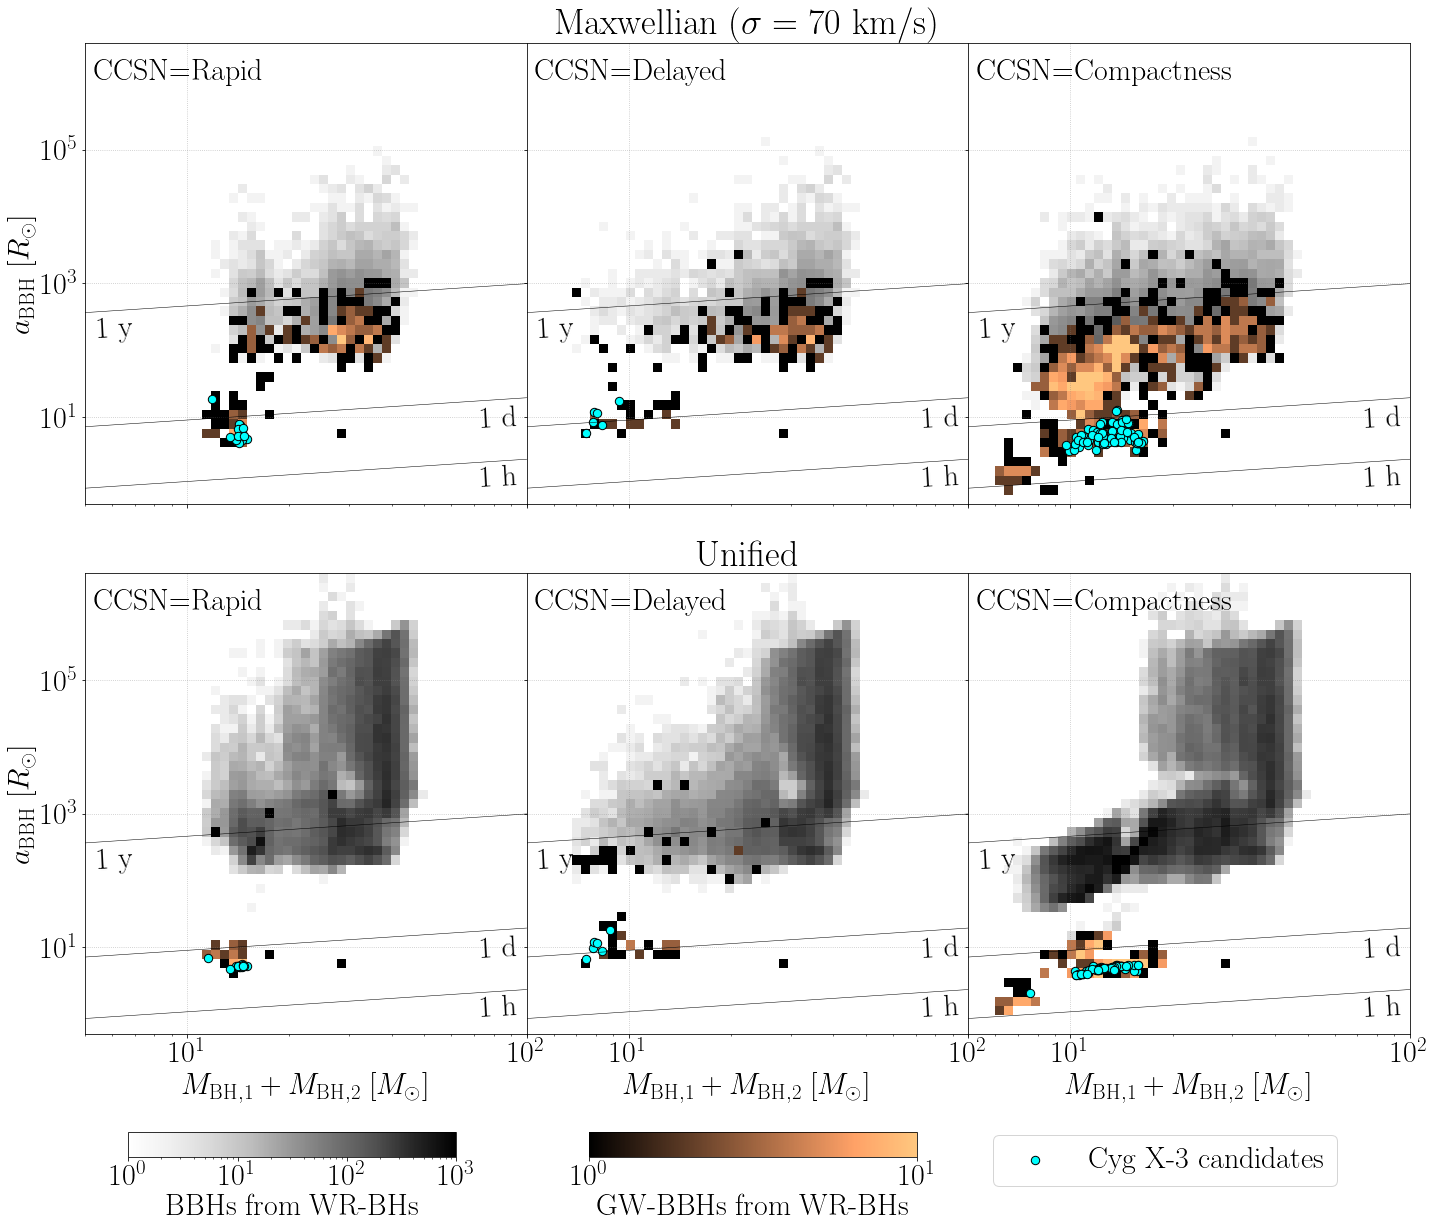

In [9]:
kicklabels = [r'Maxwellian ($\sigma=70$ km/s)',r'Unified']
kicklist = ['hobbspure70','unified265']
SNlist = ['rap','del','com']
SNlabels = ['CCSN=Rapid','CCSN=Delayed','CCSN=Compactness']
# set parameters
plt.rcParams.update({'text.usetex': True, 
                     'font.family': 'Helvetica', 
                     'font.size': 30})



fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True, figsize=(20,17))
vminall,vmaxall=1,1000
vmingw,vmaxgw =1,10
#x = np.linspace(xmin,xmax,1)
xmin,xmax = 5,1e2
xedges = np.logspace(np.log10(xmin),np.log10(xmax), 50)
yedges = np.logspace(np.log10(0.5),np.log10(4e6), 50)
Z = '02'




for SN, SNlabel, icol in zip(SNlist, SNlabels, np.arange(0,len(SNlist))):
    for kick, irow in zip(kicklist, np.arange(0,len(kicklist))):
        #########################################
        ########  extract dataframes  ###########
        ##########################################
        path_results = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick}/ppisn_{ppisn}'  # path to new folder with all useful results
        
        pall,iall,fall,rall= Extract(dfname0)
        p,i,f,r = Extract(dfname1)
        p2,i2,f2,r2 = Extract(dfname2)

        if ppisn!= 'only':
            dfname = dfname2
            out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname2)
            deltaRLOstableCE = RLOstableCEf - RLOstableCEi
            deltaRLOstable = RLOstablef - RLOstablei

            i_i2, f_f2= Filtername(i,i2), Filtername(f,i2)    # initial and final WRBH time of the cyg x-3
            i_RLOstableCE, f_RLOstableCE = Filtername(i,RLOstableCEi), Filtername(f,RLOstableCEf)  # "" that undergo STABLE
            i_RLOstable, f_RLOstable = Filtername(i,RLOstablei), Filtername(f,RLOstablef) # "" that undergo UNSTABLE

            # deltas of the first dataframes that undergo also the second condition
            delta_if2 = f2 - i2
            delta_if_if2 = f_f2 - i_i2
            delta_if_RLOstable = f_RLOstable - i_RLOstable
            delta_if_RLOstableCE = f_RLOstableCE - i_RLOstableCE
        else:
            dfname=dfname1

        delta_ifall = fall-iall
        delta_if = f-i


        ############ plot ################
        
        
        #remnants
        counts, xedg,yedg = np.histogram2d(rall.Mass_0.values + rall.Mass_1.values, rall.Semimajor.values, bins= [xedges,yedges])
        h1 = axs[irow][icol].hist2d(rall.Mass_0.values + rall.Mass_1.values, rall.Semimajor.values, bins=(xedges,yedges), cmap='Greys',norm=colors.LogNorm(vmin=vminall, vmax=vmaxall))
        counts2, xedg,yedg = np.histogram2d(r.Mass_0.values + r.Mass_1.values, r.Semimajor.values, bins= [xedges,yedges])
        h2 = axs[irow][icol].hist2d(r.Mass_0.values + r.Mass_1.values, r.Semimajor.values, bins=(xedges,yedges), cmap='copper',norm=colors.LogNorm(vmin=vmingw, vmax=vmaxgw))

        axs[irow][icol].scatter(r2.Mass_0.values + r2.Mass_1.values, r2.Semimajor.values,color='cyan',ec='k',s=70, label='Cyg X-3 candidates')

        axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1.),KeplerA(xmax,0,1.)], color='k', linestyle='solid',lw=0.5) # 1 yr
        axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1./365.),KeplerA(xmax,0,1./365.)], color='k', linestyle='solid',lw=0.5) # 1 day
        axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1./(365.*24.)),KeplerA(xmax,0,1./(365.*24))], color='k', linestyle='solid',lw=0.5) # 1 hour
        axs[irow][icol].annotate('1 y',xy=(5.4,150),rotation=3)
        axs[irow][icol].annotate('1 d', xy=(73,7),rotation=3)
        axs[irow][icol].annotate('1 h',xy=(73,0.9),rotation=3)
        
        if irow == 1:
            axs[irow][icol].set_xlabel(r'$M_{\rm BH,1} + M_{\rm BH,2}$ [$M_\odot$]')

        axs[irow][icol].annotate(SNlabel, (0.02,0.92),xycoords='axes fraction', color='k',ha='left')
        axs[irow][icol].set_xscale('log')
        axs[irow][icol].set_yscale('log')
        axs[irow][icol].grid(color='grey',alpha=0.5, linestyle='dotted')
    


axs[0][0].set_ylabel(r'$a_{\rm BBH}$ [$R_\odot$]')
axs[1][0].set_ylabel(r'$a_{\rm BBH}$ [$R_\odot$]')



p0 = axs[1][0].get_position().get_points().flatten()
p1 = axs[1][1].get_position().get_points().flatten()
p2 = axs[1][2].get_position().get_points().flatten()
ax_cbar = fig.add_axes([0.09, 0.05, p0[2]-p0[0], 0.02])
ax_cbar1 = fig.add_axes([0.41, 0.05, p1[2]-p1[0], 0.02])

#ticklabels = [r'$10^0$','','','','','','','','','$10^1$']
#ticks = [1,2,3,4,5,6,7,8,9,10]
fig.colorbar(h1[3], cax=ax_cbar,label='BBHs from WR-BHs', orientation='horizontal')
cbar = fig.colorbar(h2[3], cax=ax_cbar1, label='GW-BBHs from WR-BHs',orientation='horizontal')
#cbar.ax.set_xticklabels(ticklabels)
cbar.ax.minorticks_off()



handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.94,0.08))   


grid = plt.GridSpec(2,3)
create_subtitle(fig, grid[0, ::], kicklabels[0])
create_subtitle(fig, grid[1, ::], kicklabels[1])
plt.subplots_adjust(bottom=0.15,top=0.96, left=0.06,right=0.98,wspace=0, hspace=0.15)
#plt.tight_layout()
plt.show()
fig.savefig(f'{path_plots}/kickcompare_rem_{Z}_beamer.pdf')

# Back to latex

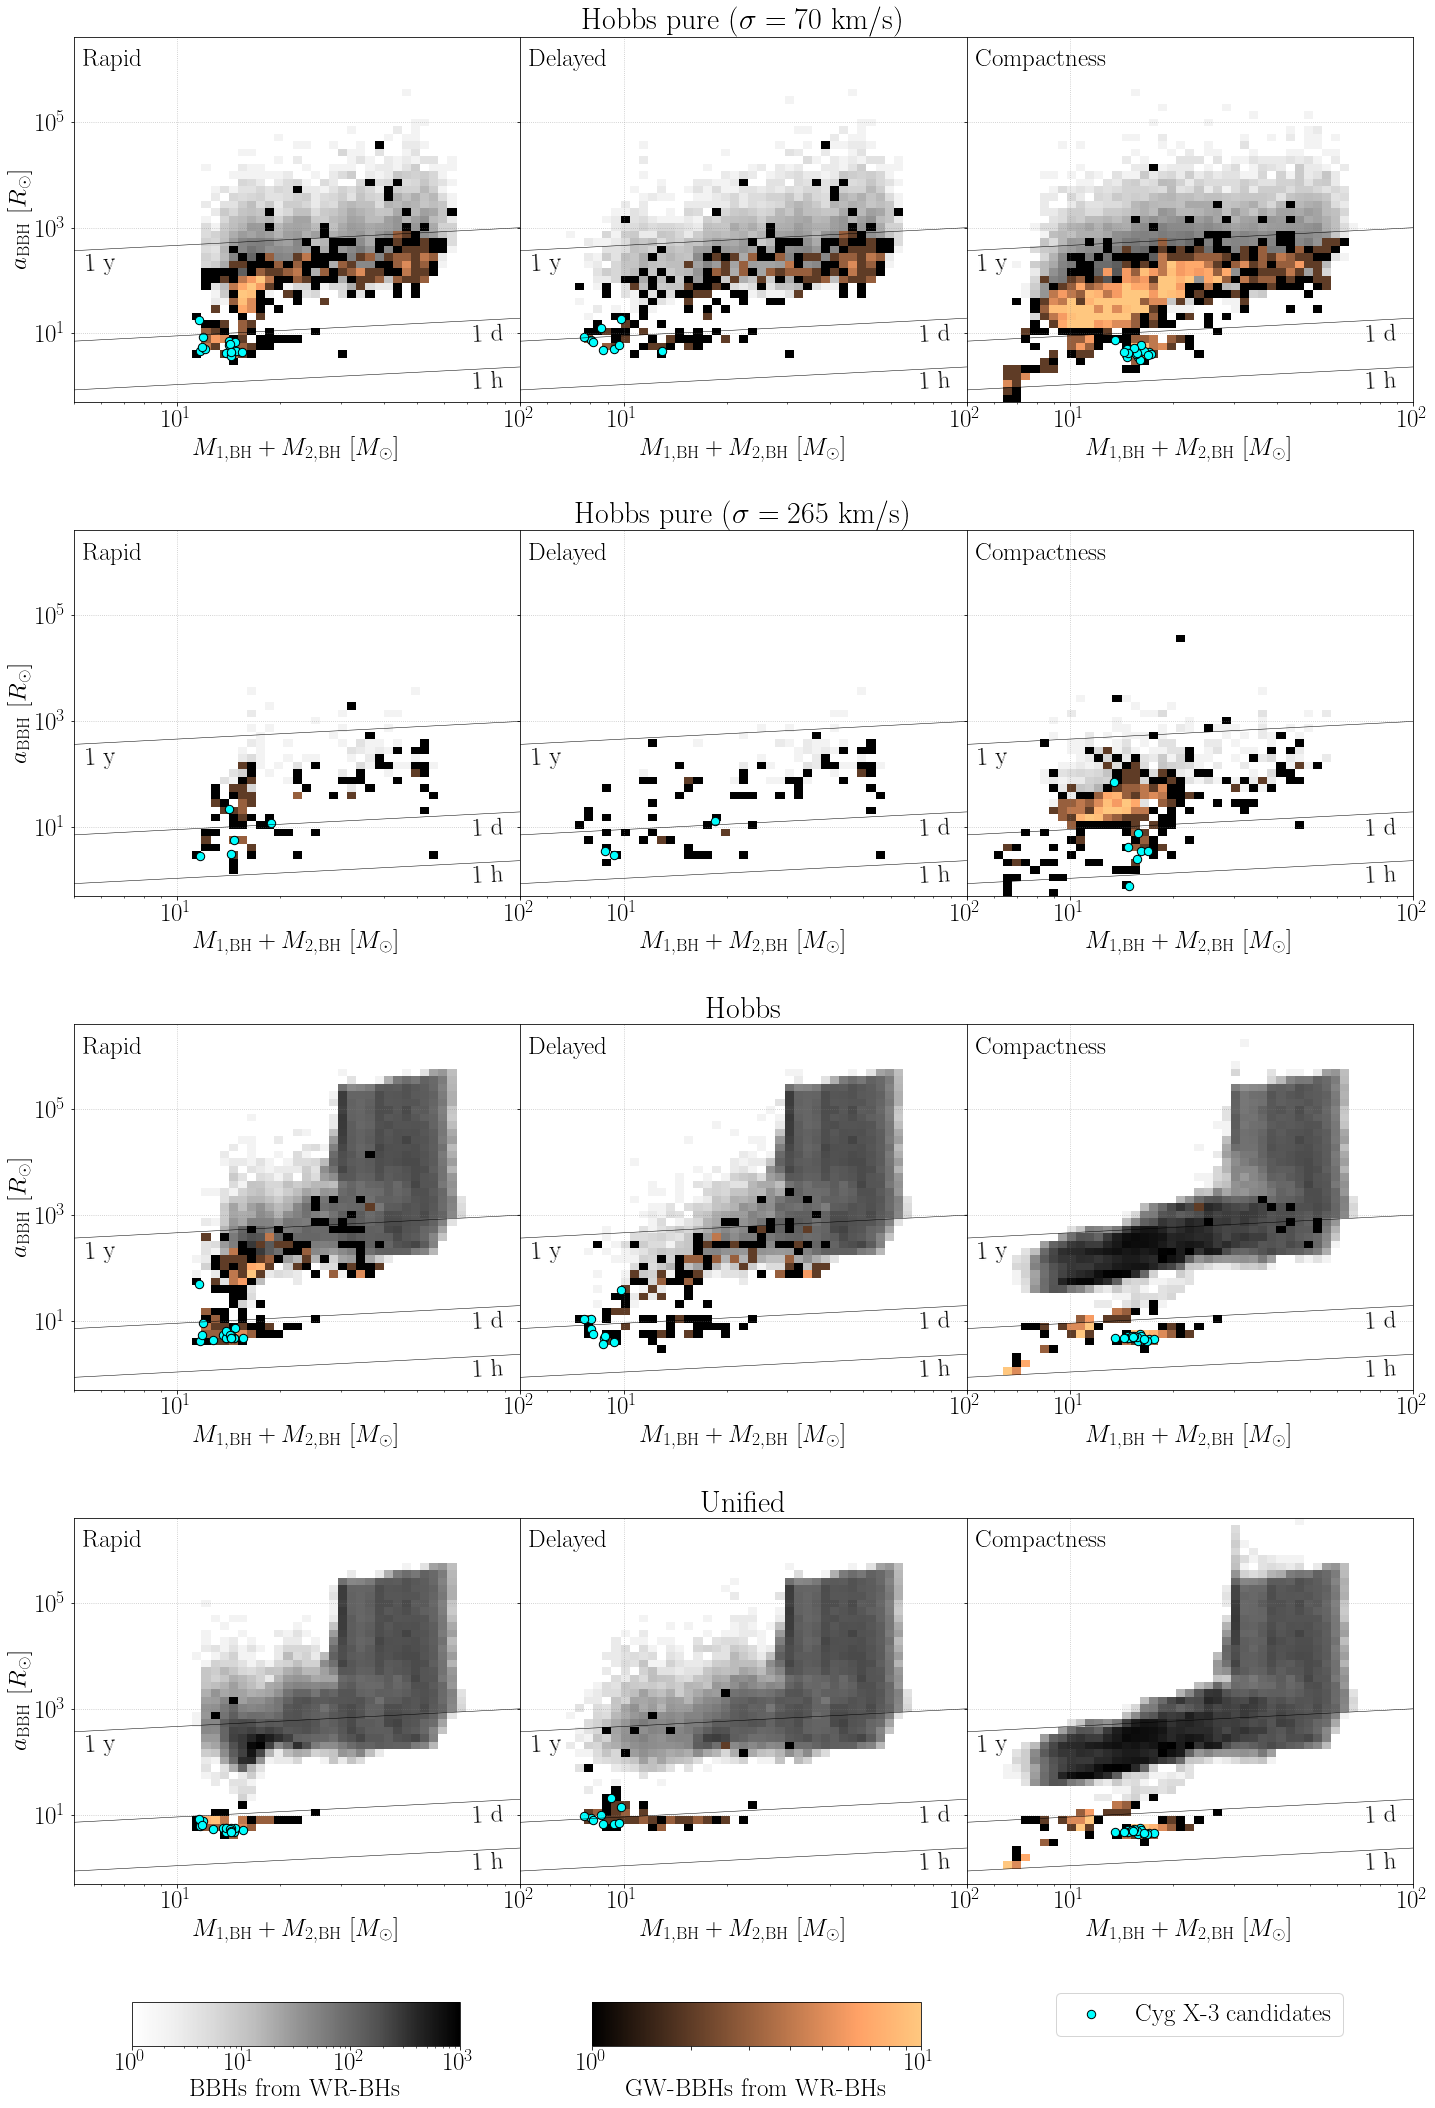

In [19]:
# set parameters
plt.rcParams.update({'text.usetex': True, 
                     'font.family': 'Helvetica', 
                     'font.size': 25})



fig, axs = plt.subplots(nrows=4, ncols=3, sharey=True, figsize=(20,30))
vminall,vmaxall=1,1000
vmingw,vmaxgw =1,10
#x = np.linspace(xmin,xmax,1)
xmin,xmax = 5,1e2
xedges = np.logspace(np.log10(xmin),np.log10(xmax), 50)
yedges = np.logspace(np.log10(0.5),np.log10(4e6), 50)
Z = '015'




for SN, SNlabel, icol in zip(SNlist, SNlabels, np.arange(0,len(SNlist))):
    for kick, irow in zip(kicklist, np.arange(0,len(kicklist))):
        #########################################
        ########  extract dataframes  ###########
        ##########################################
        path_results = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick}/ppisn_{ppisn}'  # path to new folder with all useful results
        
        pall,iall,fall,rall= Extract(dfname0)
        p,i,f,r = Extract(dfname1)
        p2,i2,f2,r2 = Extract(dfname2)

        if ppisn!= 'only':
            dfname = dfname2
            out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname2)
            deltaRLOstableCE = RLOstableCEf - RLOstableCEi
            deltaRLOstable = RLOstablef - RLOstablei

            i_i2, f_f2= Filtername(i,i2), Filtername(f,i2)    # initial and final WRBH time of the cyg x-3
            i_RLOstableCE, f_RLOstableCE = Filtername(i,RLOstableCEi), Filtername(f,RLOstableCEf)  # "" that undergo STABLE
            i_RLOstable, f_RLOstable = Filtername(i,RLOstablei), Filtername(f,RLOstablef) # "" that undergo UNSTABLE

            # deltas of the first dataframes that undergo also the second condition
            delta_if2 = f2 - i2
            delta_if_if2 = f_f2 - i_i2
            delta_if_RLOstable = f_RLOstable - i_RLOstable
            delta_if_RLOstableCE = f_RLOstableCE - i_RLOstableCE
        else:
            dfname=dfname1

        delta_ifall = fall-iall
        delta_if = f-i


        ############ plot ################
        
        
        #remnants
        counts, xedg,yedg = np.histogram2d(rall.Mass_0.values + rall.Mass_1.values, rall.Semimajor.values, bins= [xedges,yedges])
        h1 = axs[irow][icol].hist2d(rall.Mass_0.values + rall.Mass_1.values, rall.Semimajor.values, bins=(xedges,yedges), cmap='Greys',norm=colors.LogNorm(vmin=vminall, vmax=vmaxall))
        counts2, xedg,yedg = np.histogram2d(r.Mass_0.values + r.Mass_1.values, r.Semimajor.values, bins= [xedges,yedges])
        h2 = axs[irow][icol].hist2d(r.Mass_0.values + r.Mass_1.values, r.Semimajor.values, bins=(xedges,yedges), cmap='copper',norm=colors.LogNorm(vmin=vmingw, vmax=vmaxgw))

        axs[irow][icol].scatter(r2.Mass_0.values + r2.Mass_1.values, r2.Semimajor.values,color='cyan',ec='k',s=70, label='Cyg X-3 candidates')

        axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1.),KeplerA(xmax,0,1.)], color='k', linestyle='solid',lw=0.5) # 1 yr
        axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1./365.),KeplerA(xmax,0,1./365.)], color='k', linestyle='solid',lw=0.5) # 1 day
        axs[irow][icol].plot([xmin,xmax], [KeplerA(xmin,0,1./(365.*24.)),KeplerA(xmax,0,1./(365.*24))], color='k', linestyle='solid',lw=0.5) # 1 hour
        axs[irow][icol].annotate('1 y',xy=(5.4,150),rotation=3)
        axs[irow][icol].annotate('1 d', xy=(73,7),rotation=3)
        axs[irow][icol].annotate('1 h',xy=(73,0.9),rotation=3)

        axs[irow][icol].set_xlabel(r'$M_{\rm 1,BH} + M_{\rm 2,BH}$ [$M_\odot$]')

        axs[irow][icol].annotate(SNlabel, (0.02,0.92),xycoords='axes fraction', color='k',ha='left')
        axs[irow][icol].set_xscale('log')
        axs[irow][icol].set_yscale('log')
        axs[irow][icol].grid(color='grey',alpha=0.5, linestyle='dotted')
    


axs[0][0].set_ylabel(r'$a_{\rm BBH}$ [$R_\odot$]')
axs[1][0].set_ylabel(r'$a_{\rm BBH}$ [$R_\odot$]')
axs[2][0].set_ylabel(r'$a_{\rm BBH}$ [$R_\odot$]')
axs[3][0].set_ylabel(r'$a_{\rm BBH}$ [$R_\odot$]')



p0 = axs[2][0].get_position().get_points().flatten()
p1 = axs[2][1].get_position().get_points().flatten()
p2 = axs[2][2].get_position().get_points().flatten()
ax_cbar = fig.add_axes([0.09, 0.05, p0[2]-p0[0], 0.02])
ax_cbar1 = fig.add_axes([0.41, 0.05, p1[2]-p1[0], 0.02])

ticklabels = [r'$10^0$','','','','','','','','','$10^1$']
ticks = [1,2,3,4,5,6,7,8,9,10]
fig.colorbar(h1[3], cax=ax_cbar,label='BBHs from WR-BHs', orientation='horizontal')
cbar = fig.colorbar(h2[3], cax=ax_cbar1, label='GW-BBHs from WR-BHs',orientation='horizontal',ticks=ticks)
cbar.ax.set_xticklabels(ticklabels)
cbar.ax.minorticks_off()



handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.94,0.08))   


grid = plt.GridSpec(4,3)
create_subtitle(fig, grid[0, ::], kicklabels[0])
create_subtitle(fig, grid[1, ::], kicklabels[1])
create_subtitle(fig, grid[2, ::], kicklabels[2])
create_subtitle(fig, grid[3, ::], kicklabels[3])
plt.subplots_adjust(top=0.98, left=0.05,right=0.98,wspace=0, hspace=0.35)
#plt.tight_layout()
plt.show()
fig.savefig(f'{path_plots}/kickcompare_rem_{Z}.pdf')

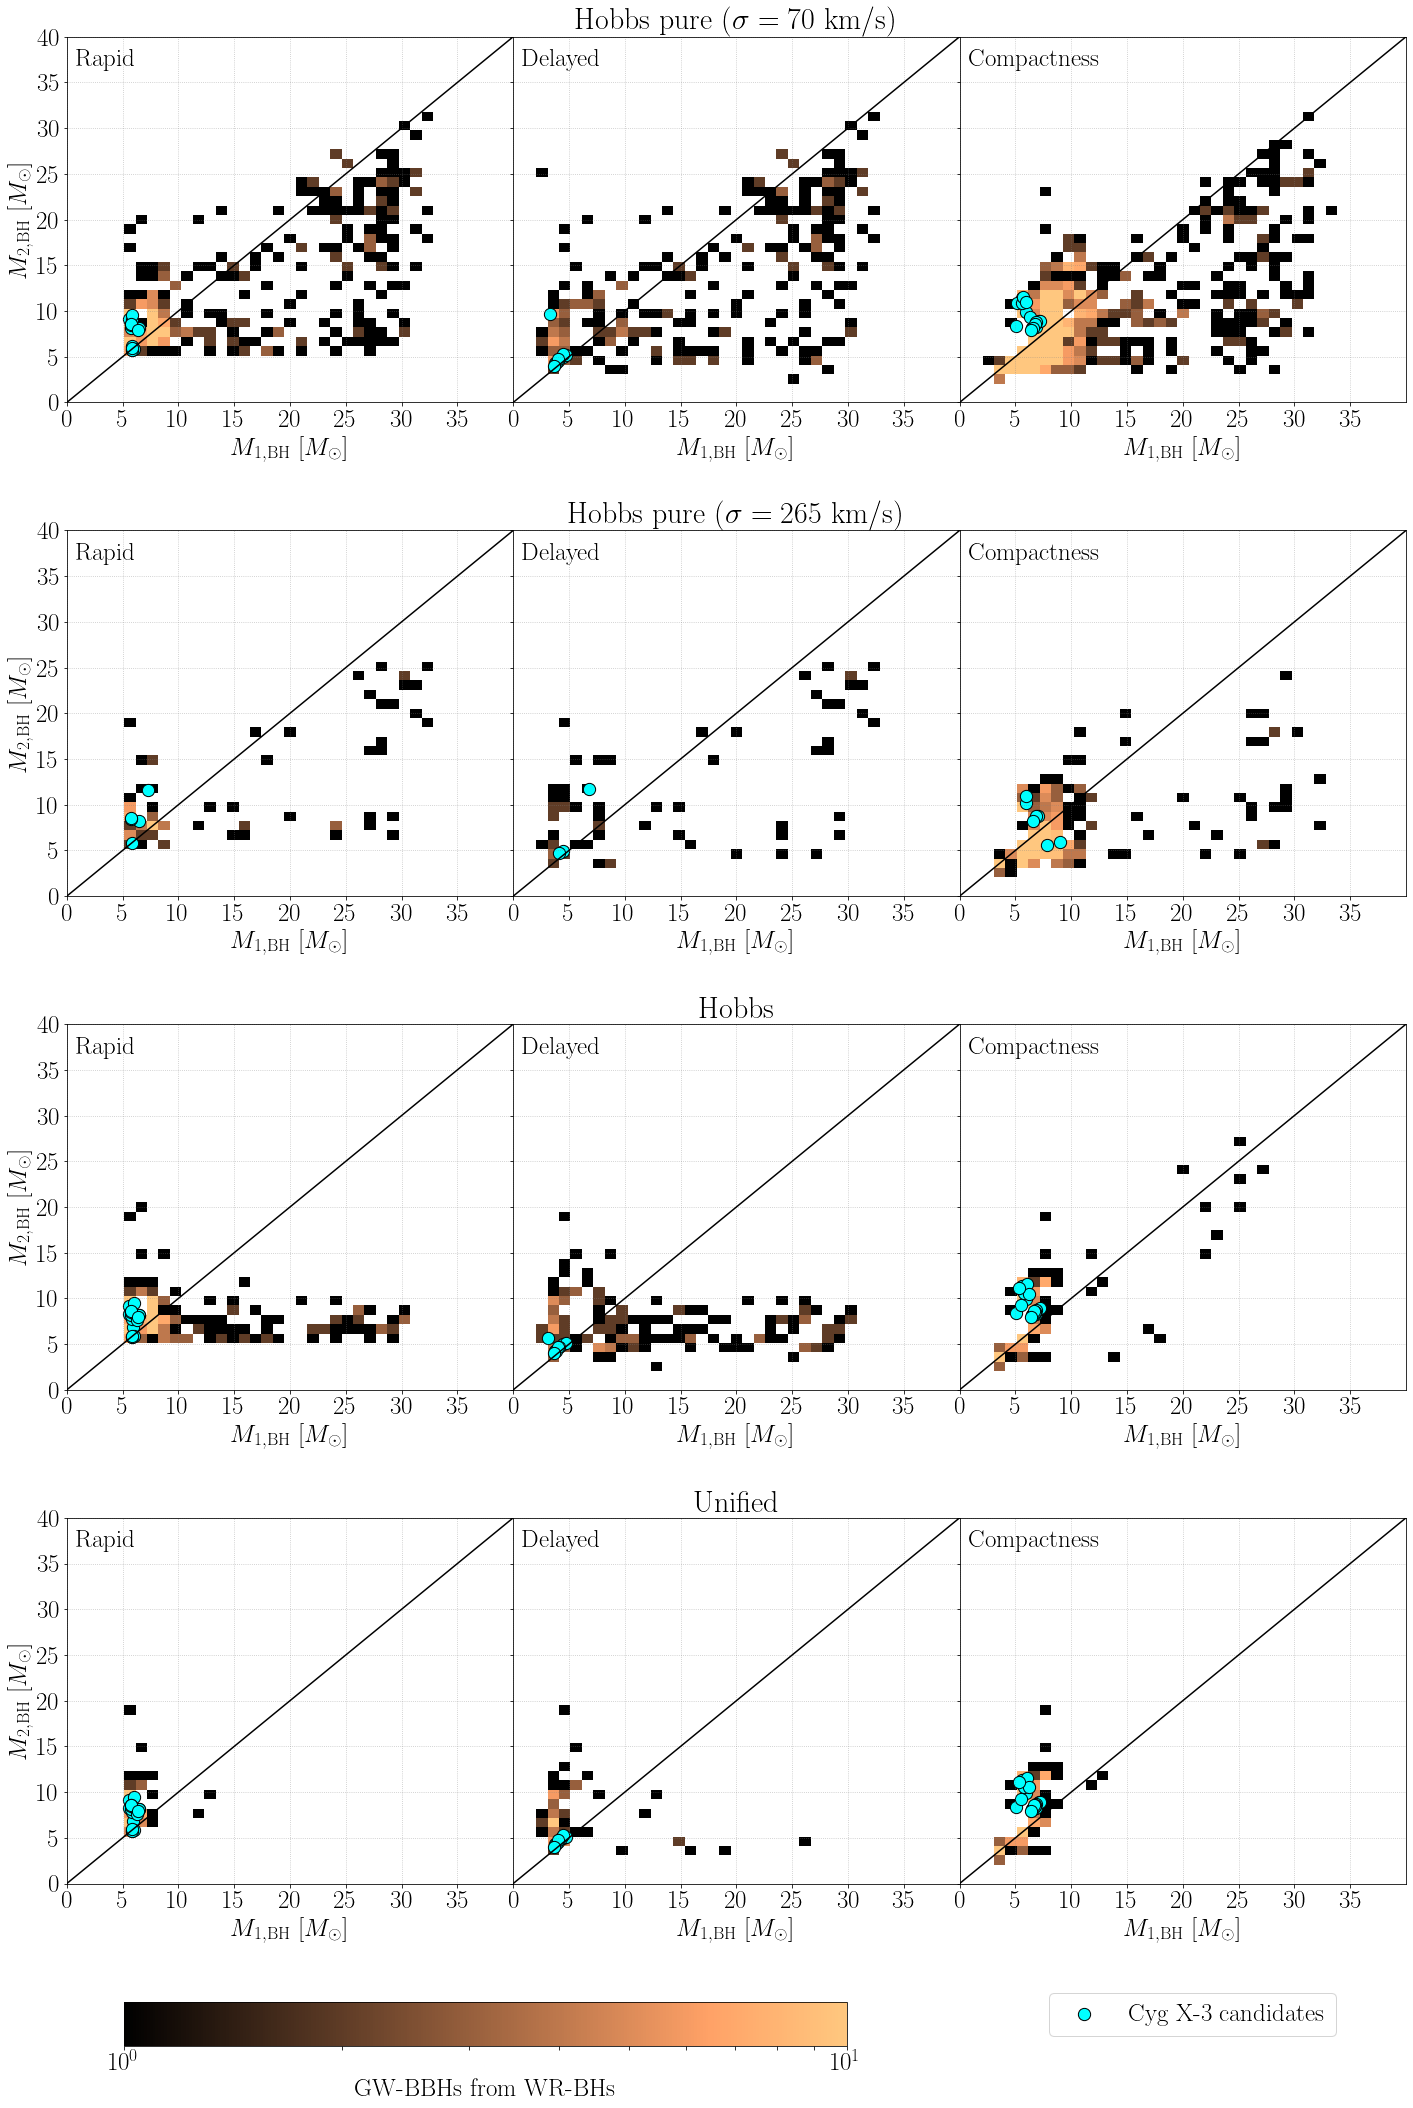

In [20]:
# set parameters
plt.rcParams.update({'text.usetex': True, 
                     'font.family': 'Helvetica', 
                     'font.size': 25})


fig, axs = plt.subplots(nrows=4, ncols=3, sharey=True, figsize=(20,30))
vminall,vmaxall=1,1000
vmingw,vmaxgw =1,10
#x = np.linspace(xmin,xmax,1)
xmin,xmax = 0,40
# xedges = np.logspace(np.log10(xmin),np.log10(xmax), 25) # 2 msun bin width
# yedges = np.logspace(np.log10(xmin),np.log10(xmax), 25)
xedges = np.linspace(xmin,xmax, 40) 
yedges = np.linspace(xmin,xmax, 40)
Z = '015'




for SN, SNlabel, icol in zip(SNlist, SNlabels, np.arange(0,len(SNlist))):
    for kick, irow in zip(kicklist, np.arange(0,len(kicklist))):
        #########################################
        ########  extract dataframes  ###########
        ##########################################
        path_results = f'./v_{version}/{Nsim}_Z{Z}_{SN}_{kick}/ppisn_{ppisn}'  # path to new folder with all useful results
        
        pall,iall,fall,rall= Extract(dfname0)
        p,i,f,r = Extract(dfname1)
        p2,i2,f2,r2 = Extract(dfname2)

        if ppisn!= 'only':
            dfname = dfname2
            out, RLOstablei, RLOstablef, RLOstableCEi, RLOstableCEf, RLOrecap = RLOtype(dfname2)
            deltaRLOstableCE = RLOstableCEf - RLOstableCEi
            deltaRLOstable = RLOstablef - RLOstablei

            i_i2, f_f2= Filtername(i,i2), Filtername(f,i2)    # initial and final WRBH time of the cyg x-3
            i_RLOstableCE, f_RLOstableCE = Filtername(i,RLOstableCEi), Filtername(f,RLOstableCEf)  # "" that undergo STABLE
            i_RLOstable, f_RLOstable = Filtername(i,RLOstablei), Filtername(f,RLOstablef) # "" that undergo UNSTABLE

            # deltas of the first dataframes that undergo also the second condition
            delta_if2 = f2 - i2
            delta_if_if2 = f_f2 - i_i2
            delta_if_RLOstable = f_RLOstable - i_RLOstable
            delta_if_RLOstableCE = f_RLOstableCE - i_RLOstableCE
        else:
            dfname=dfname1

        delta_ifall = fall-iall
        delta_if = f-i


        ############ plot ################


        #remnants
        #counts, xedg,yedg = np.histogram2d(pall.Mass_0.values, pall.Mass_1.values, bins= [xedges,yedges])
        #h1 = axs[irow][icol].hist2d(pall.Mass_0.values, pall.Mass_1.values, bins=(xedges,yedges), cmap='Greys',norm=colors.LogNorm(vmin=vminall, vmax=vmaxall))
        counts2, xedg,yedg = np.histogram2d(r.Mass_0.values, r.Mass_1.values, bins= [xedges,yedges])
        h2 = axs[irow][icol].hist2d(r.Mass_0.values, r.Mass_1.values,  bins=(xedges,yedges), cmap='copper',norm=colors.LogNorm(vmin=vmingw, vmax=vmaxgw))

        axs[irow][icol].scatter(r2.Mass_0.values, r2.Mass_1.values, color='cyan',ec='k',s=150, label='Cyg X-3 candidates')
        axs[irow][icol].plot([xmin,xmax],[xmin,xmax],color='k',linestyle='solid')
        
        axs[irow][icol].set_xlabel(r'$M_{\rm 1,BH}$ [$M_\odot$]')
        axs[irow][icol].set_xticks(np.arange(xmin,36,5))
        axs[irow][icol].set_yticks(np.arange(xmin,41,5))
        axs[irow][icol].set_xlim(0,40)

        axs[irow][icol].annotate(SNlabel, (0.02,0.92),xycoords='axes fraction', color='k',ha='left')
        #axs[irow][icol].set_xscale('log')
        #axs[irow][icol].set_yscale('log')
        axs[irow][icol].grid(color='grey',alpha=0.5, which='both',linestyle='dotted')
    


axs[0][0].set_ylabel(r'$M_{\rm 2,BH}$ [$M_\odot$]')
axs[1][0].set_ylabel(r'$M_{\rm 2,BH}$ [$M_\odot$]')
axs[2][0].set_ylabel(r'$M_{\rm 2,BH}$ [$M_\odot$]')
axs[3][0].set_ylabel(r'$M_{\rm 2,BH}$ [$M_\odot$]')



p0 = axs[2][0].get_position().get_points().flatten()
p1 = axs[2][1].get_position().get_points().flatten()
p2 = axs[2][2].get_position().get_points().flatten()
#ax_cbar = fig.add_axes([0.09, 0.05, p0[2]-p0[0], 0.02])
ax_cbar1 = fig.add_axes([0.09, 0.05, p1[2]-p0[0], 0.02])

ticklabels = [r'$10^0$','','','','','','','','','$10^1$']
ticks = [1,2,3,4,5,6,7,8,9,10]
#fig.colorbar(h1[3], cax=ax_cbar,label='BBHs from WR-BHs', orientation='horizontal')
cbar = fig.colorbar(h2[3], cax=ax_cbar1, label='GW-BBHs from WR-BHs',orientation='horizontal',ticks=ticks)
cbar.ax.set_xticklabels(ticklabels)
cbar.ax.minorticks_off()



handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.94,0.08))   


grid = plt.GridSpec(4,3)
create_subtitle(fig, grid[0, ::], kicklabels[0])
create_subtitle(fig, grid[1, ::], kicklabels[1])
create_subtitle(fig, grid[2, ::], kicklabels[2])
create_subtitle(fig, grid[3, ::], kicklabels[3])
plt.subplots_adjust(top=0.98, left=0.05,right=0.98,wspace=0, hspace=0.35)
#plt.tight_layout()
plt.show()
fig.savefig(f'{path_plots}/kickcompare_MBHMBH_{Z}.pdf')